In [1]:
# Author: Soma Ezzadpanah
# Section 1: Setup and Data Loading
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from libpysal.weights import Queen
from esda.moran import Moran

# ML models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

# loading mortality data
mortality_data = pd.read_csv('mortality_rate.csv')

# display first few rows and data structure
print("Mortality Data Preview:")
print(mortality_data.head())
print("\nColumn Names:")
print(mortality_data.columns)
print("\nData Types:")
print(mortality_data.dtypes)

Mortality Data Preview:
   Year                                     113 Cause Name  \
0  2017  Accidents (unintentional injuries) (V01-X59,Y8...   
1  2017                          Alzheimer's disease (G30)   
2  2017                 Cerebrovascular diseases (I60-I69)   
3  2017       Chronic lower respiratory diseases (J40-J47)   
4  2017                        Diabetes mellitus (E10-E14)   

               Cause Name    State  Deaths  Age-adjusted Death Rate  
0  Unintentional injuries  Alabama    2703                     53.8  
1     Alzheimer's disease  Alabama    2563                     45.2  
2                  Stroke  Alabama    2931                     50.0  
3                    CLRD  Alabama    3484                     57.8  
4                Diabetes  Alabama    1173                     19.8  

Column Names:
Index(['Year', '113 Cause Name', 'Cause Name', 'State', 'Deaths',
       'Age-adjusted Death Rate'],
      dtype='object')

Data Types:
Year                         int

In [2]:
# Section 2: Data Cleaning and Preprocessing
# convert year to numeric and filter for 2010-2017
mortality_data['Year'] = pd.to_numeric(mortality_data['Year'], errors='coerce')
mortality_data = mortality_data[(mortality_data['Year'] >= 2010) & (mortality_data['Year'] <= 2017)]

# data quality checks
print("\nUnique Years After Filtering:")
print(mortality_data['Year'].unique())
print("\nMissing Values:")
print(mortality_data.isnull().sum())
print("\nCritical Column Data Types:")
print(mortality_data['Deaths'].dtype)
print(mortality_data['Age-adjusted Death Rate'].dtype)


Unique Years After Filtering:
[2017 2016 2015 2014 2013 2012 2011 2010]

Missing Values:
Year                       0
113 Cause Name             0
Cause Name                 0
State                      0
Deaths                     0
Age-adjusted Death Rate    0
dtype: int64

Critical Column Data Types:
int64
float64


In [3]:
# Section 3: Load and Clean Income Data
# load all income files
income_files = glob.glob('income_*.csv')
income_dfs = []

for file in income_files:
    df = pd.read_csv(file)
    year = int(file.split('_')[1].split('.')[0])
    df['Year'] = year
    income_dfs.append(df)

# combine all income data
income_data = pd.concat(income_dfs, ignore_index=True)

# clean income data
unwanted_labels = [
    'PERCENT IMPUTED',
    '    Household income in the past 12 months',
    '    Family income in the past 12 months',
    '    Nonfamily income in the past 12 months'
]
income_data = income_data[~income_data['Label (Grouping)'].isin(unwanted_labels)]
income_data = income_data[[col for col in income_data.columns if 'Margin of Error' not in col]]

print("\nIncome Data Columns:")
print(income_data.columns)


Income Data Columns:
Index(['Label (Grouping)', 'Alabama!!Households!!Estimate',
       'Alabama!!Families!!Estimate',
       'Alabama!!Married-couple families!!Estimate',
       'Alabama!!Nonfamily households!!Estimate',
       'Alaska!!Households!!Estimate', 'Alaska!!Families!!Estimate',
       'Alaska!!Married-couple families!!Estimate',
       'Alaska!!Nonfamily households!!Estimate',
       'Arizona!!Households!!Estimate',
       ...
       'Wisconsin!!Nonfamily households!!Estimate',
       'Wyoming!!Households!!Estimate', 'Wyoming!!Families!!Estimate',
       'Wyoming!!Married-couple families!!Estimate',
       'Wyoming!!Nonfamily households!!Estimate',
       'Puerto Rico!!Households!!Estimate', 'Puerto Rico!!Families!!Estimate',
       'Puerto Rico!!Married-couple families!!Estimate',
       'Puerto Rico!!Nonfamily households!!Estimate', 'Year'],
      dtype='object', length=210)


In [4]:
# Section 4: Reshape and Organize Income Data
# reshape to long format
income_data_long = pd.melt(
    income_data,
    id_vars=['Label (Grouping)', 'Year'],
    var_name='State_Estimate',
    value_name='Value'
)

# split state and estimate type
split_columns = income_data_long['State_Estimate'].str.split('!!', n=1, expand=True)
income_data_long['State'] = split_columns[0]
income_data_long['Estimate_Type'] = split_columns[1]

# check for malformed entries
print("\nRows with malformed State_Estimate:")
print(income_data_long[income_data_long['Estimate_Type'].isnull()])

# pivot to wide format
income_data_pivot = income_data_long.pivot_table(
    index=['Year', 'State', 'Label (Grouping)'],
    columns='Estimate_Type',
    values='Value',
    aggfunc='first'
).reset_index()

print("\nPivoted Income Data Preview:")
print(income_data_pivot.head())


Rows with malformed State_Estimate:
Empty DataFrame
Columns: [Label (Grouping), Year, State_Estimate, Value, State, Estimate_Type]
Index: []

Pivoted Income Data Preview:
Estimate_Type  Year    State      Label (Grouping) Families!!Estimate  \
0              2010  Alabama    $10,000 to $14,999               4.4%   
1              2010  Alabama  $100,000 to $149,999              11.8%   
2              2010  Alabama    $15,000 to $24,999              11.3%   
3              2010  Alabama  $150,000 to $199,999               4.0%   
4              2010  Alabama      $200,000 or more               2.9%   

Estimate_Type Households!!Estimate Married-couple families!!Estimate  \
0                             7.4%                              2.3%   
1                             9.0%                             15.7%   
2                            13.7%                              7.7%   
3                             3.0%                              5.4%   
4                            

In [5]:
# Section 5: Combine and Clean Income Columns
# filter for median income
income_data_filtered = income_data_pivot[
    income_data_pivot['Label (Grouping)'] == 'Median income (dollars)'
].copy()

# rename columns
income_data_filtered.rename(columns={
    'Families!!Estimate': 'Median_Family_Income',
    'Households!!Estimate': 'Median_Household_Income',
    'Married-couple families!!Estimate': 'Median_MarriedCouple_Income',
    'Nonfamily households!!Estimate': 'Median_Nonfamily_Income'
}, inplace=True)

# convert income to numeric
income_columns = [
    'Median_Household_Income',
    'Median_Nonfamily_Income',
    'Median_Family_Income',
    'Median_MarriedCouple_Income'
]

for col in income_columns:
    income_data_filtered[col] = (
        income_data_filtered[col]
        .str.replace(',', '', regex=False)
        .astype(float)
    )

In [6]:
# Section 6: Merge Mortality and Income Data
# merge datasets
merged_data = pd.merge(
    mortality_data,
    income_data_filtered,
    on=['State', 'Year'],
    how='inner'
)

# encode cause names
le_cause = LabelEncoder()
merged_data['Cause_Code'] = le_cause.fit_transform(merged_data['Cause Name'])

print("\nMerged Data Preview:")
print(merged_data.head())
print("\nMerged Data Columns:")
print(merged_data.columns)


Merged Data Preview:
   Year                                     113 Cause Name  \
0  2017  Accidents (unintentional injuries) (V01-X59,Y8...   
1  2017                          Alzheimer's disease (G30)   
2  2017                 Cerebrovascular diseases (I60-I69)   
3  2017       Chronic lower respiratory diseases (J40-J47)   
4  2017                        Diabetes mellitus (E10-E14)   

               Cause Name    State  Deaths  Age-adjusted Death Rate  \
0  Unintentional injuries  Alabama    2703                     53.8   
1     Alzheimer's disease  Alabama    2563                     45.2   
2                  Stroke  Alabama    2931                     50.0   
3                    CLRD  Alabama    3484                     57.8   
4                Diabetes  Alabama    1173                     19.8   

          Label (Grouping)  Median_Family_Income  Median_Household_Income  \
0  Median income (dollars)               61512.0                  48123.0   
1  Median income (dollar

In [7]:
# Section 7: Load and Clean Education Data
# define required education levels
required_education_levels = [
    'Population 25 years and over',
    'Less than 9th grade',
    '9th to 12th grade, no diploma',
    'High school graduate (includes equivalency)',
    'Some college, no degree',
    "Associate's degree",
    "Bachelor's degree",
    'Graduate or professional degree'
]

# load education files
education_files = glob.glob('Education_*.csv')
education_dfs = []

for file in education_files:
    year = int(file.split('_')[1].split('.')[0])
    df = pd.read_csv(file)
    df['Label (Grouping)'] = df['Label (Grouping)'].str.strip()
    df = df[[col for col in df.columns if 'Percent' not in col]]
    df = df[df['Label (Grouping)'].isin(required_education_levels)]
    df['Year'] = year
    education_dfs.append(df)

# combine education data
education_data = pd.concat(education_dfs, ignore_index=True)

print("\nEducation Data Preview:")
print(education_data.head())


Education Data Preview:
                              Label (Grouping) Alabama!!Estimate  \
0                 Population 25 years and over         3,300,713   
1                          Less than 9th grade           157,797   
2                9th to 12th grade, no diploma           333,897   
3  High school graduate (includes equivalency)         1,011,236   
4                      Some college, no degree           711,231   

  Alaska!!Estimate Arizona!!Estimate Arkansas!!Estimate California!!Estimate  \
0          478,951         4,626,409          1,990,448           26,304,241   
1           10,392           265,215            100,157            2,556,147   
2           22,585           349,224            179,465            2,062,516   
3          133,928         1,105,497            681,969            5,390,935   
4          129,650         1,179,736            449,709            5,602,398   

  Colorado!!Estimate Connecticut!!Estimate Delaware!!Estimate  \
0          3,745,506

In [8]:
# Section 8: Reshape and Clean Education Data
# remove Puerto Rico
education_data = education_data.loc[:, ~education_data.columns.str.contains('Puerto Rico')]

# reshape to long format
education_data_long = pd.melt(
    education_data,
    id_vars=['Label (Grouping)', 'Year'],
    var_name='State_Estimate',
    value_name='Value'
)

# process education data
split_columns = education_data_long['State_Estimate'].str.split('!!', n=1, expand=True)
education_data_long['State'] = split_columns[0]
education_data_long['Estimate_Type'] = education_data_long['Label (Grouping)']

# clean and convert values
education_data_long = education_data_long[['Year', 'State', 'Estimate_Type', 'Value']]
education_data_long['Value'] = pd.to_numeric(
    education_data_long['Value'].str.replace(',', '', regex=True), 
    errors='coerce'
)

print("\nEducation Data Long Format:")
print(education_data_long.head())



Education Data Long Format:
   Year    State                                Estimate_Type    Value
0  2016  Alabama                 Population 25 years and over  3300713
1  2016  Alabama                          Less than 9th grade   157797
2  2016  Alabama                9th to 12th grade, no diploma   333897
3  2016  Alabama  High school graduate (includes equivalency)  1011236
4  2016  Alabama                      Some college, no degree   711231


In [9]:
# Section 9: Pivot Education Data
# pivot to wide format
education_data_pivot = education_data_long.pivot_table(
    index=['Year', 'State'],
    columns='Estimate_Type',
    values='Value',
    aggfunc='first'
).reset_index()

print("\nEducation Data Pivot Format:")
print(education_data_pivot.head())



Education Data Pivot Format:
Estimate_Type  Year       State  9th to 12th grade, no diploma  \
0              2010     Alabama                         369310   
1              2010      Alaska                          27668   
2              2010     Arizona                         333890   
3              2010    Arkansas                         205920   
4              2010  California                        2115091   

Estimate_Type  Associate's degree  Bachelor's degree  \
0                          225382             439863   
1                           37106              83346   
2                          336950             691889   
3                          121711             252888   
4                         1831667            4610875   

Estimate_Type  Graduate or professional degree  \
0                                       252832   
1                                        42477   
2                                       382146   
3                                   

In [10]:
# Section 10: Load and Clean AGR Data
# define required categories
required_age_labels = [
    'Under 5 years', '5 to 9 years', '10 to 14 years', '15 to 19 years',
    '20 to 24 years', '25 to 34 years', '35 to 44 years', '45 to 54 years',
    '55 to 59 years', '60 to 64 years', '65 to 74 years', '75 to 84 years',
    '85 years and over'
]
required_gender_labels = ['Male', 'Female']

required_race_labels = [
    'White', 'Black or African American', 'American Indian and Alaska Native', 
    'Asian', 'Native Hawaiian and Other Pacific Islander', 'Some other race', 
    'Two or more races'
]

# load AGR files
agr_files = glob.glob('AGR_*.csv')
age_dfs = []
gender_dfs = []
race_dfs = []

for file in agr_files:
    year = int(file.split('_')[1].split('.')[0])
    df = pd.read_csv(file)
    df['Label (Grouping)'] = df['Label (Grouping)'].str.strip()
    df = df[[col for col in df.columns if 'Percent' not in col]]
    
    try:
        sex_age_idx = df[df['Label (Grouping)'] == 'SEX AND AGE'].index[0]
        race_idx = df[df['Label (Grouping)'] == 'RACE'].index[0]
        
        # extract age data
        age_section = df.iloc[sex_age_idx+1:race_idx].copy()
        age_mask = age_section['Label (Grouping)'].isin(required_age_labels)
        age_filtered = age_section[age_mask].copy()
        age_filtered['Year'] = year
        age_dfs.append(age_filtered)
        
        # extract gender data
        gender_mask = age_section['Label (Grouping)'].isin(required_gender_labels)
        gender_filtered = age_section[gender_mask].copy()
        gender_filtered['Year'] = year
        gender_dfs.append(gender_filtered)
        
        # extract race data
        race_section = df.iloc[race_idx+1:].copy()
        race_mask = race_section['Label (Grouping)'].isin(required_race_labels)
        race_filtered = race_section[race_mask].copy()
        race_filtered['Year'] = year
        race_dfs.append(race_filtered)
        
    except IndexError as e:
        print(f"Warning: Could not find sections in file {file}. Error: {e}")
        continue

# combine AGR data
age_data = pd.concat(age_dfs, ignore_index=True) if age_dfs else pd.DataFrame()
gender_data = pd.concat(gender_dfs, ignore_index=True) if gender_dfs else pd.DataFrame()
race_data = pd.concat(race_dfs, ignore_index=True) if race_dfs else pd.DataFrame()

print("\nAge Data Preview:")
print(age_data.head() if not age_data.empty else "No age data found")
print("\nGender Data Preview:")
print(gender_data.head() if not gender_data.empty else "No gender data found")
print("\nRace Data Preview:")
print(race_data.head(10) if not race_data.empty else "No race data found")



Age Data Preview:
  Label (Grouping) Alabama!!Estimate Alaska!!Estimate Arizona!!Estimate  \
0    Under 5 years           308,069           53,582           455,776   
1     5 to 9 years           309,658           49,870           448,623   
2   10 to 14 years           318,460           52,372           457,339   
3   15 to 19 years           348,077           51,610           460,186   
4   20 to 24 years           339,513           55,974           445,055   

  Arkansas!!Estimate California!!Estimate Colorado!!Estimate  \
0            194,451            2,528,898            342,277   
1            195,858            2,536,654            354,521   
2            201,519            2,578,286            330,545   
3            210,433            2,825,690            343,494   
4            199,923            2,782,635            350,189   

  Connecticut!!Estimate Delaware!!Estimate District of Columbia!!Estimate  \
0               201,685             56,095                         3

In [11]:
# Section 11: Reshape AGR Data
def process_agr_data(data, value_name='Estimate'):
    """Helper function to reshape AGR data"""
    data_long = pd.melt(
        data,
        id_vars=['Label (Grouping)', 'Year'],
        var_name='State_Estimate',
        value_name=value_name
    )
    
    split_cols = data_long['State_Estimate'].str.split('!!', expand=True)
    data_long['State'] = split_cols[0]
    data_long[value_name] = data_long[value_name].str.replace(',', '').astype(float)
    data_long['Category'] = data_long['Label (Grouping)']
    data_long.drop(columns=['Label (Grouping)', 'State_Estimate'], inplace=True)
    
    return data_long

# process each dataset
age_data_long = process_agr_data(age_data, 'Population')
gender_data_long = process_agr_data(gender_data, 'Population')
race_data_long = process_agr_data(race_data, 'Population')

# pivot to wide format
age_data_wide = age_data_long.pivot_table(
    index=['Year', 'State'],
    columns='Category',
    values='Population',
    aggfunc='first'
).reset_index()

gender_data_wide = gender_data_long.pivot_table(
    index=['Year', 'State'],
    columns='Category',
    values='Population',
    aggfunc='first'
).reset_index()

race_data_wide = race_data_long.pivot_table(
    index=['Year', 'State'],
    columns='Category',
    values='Population',
    aggfunc='first'
).reset_index()

print("\nAge Data (wide format):")
print(age_data_wide.head())
print("\nGender Data (wide format):")
print(gender_data_wide.head())
print("\nRace Data (wide format):")
print(race_data_wide.head())



Age Data (wide format):
Category  Year       State  10 to 14 years  15 to 19 years  20 to 24 years  \
0         2010     Alabama        318460.0        348077.0        339513.0   
1         2010      Alaska         52372.0         51610.0         55974.0   
2         2010     Arizona        457339.0        460186.0        445055.0   
3         2010    Arkansas        201519.0        210433.0        199923.0   
4         2010  California       2578286.0       2825690.0       2782635.0   

Category  25 to 34 years  35 to 44 years  45 to 54 years  5 to 9 years  \
0               601653.0        621094.0        689027.0      309658.0   
1               103690.0         93460.0        112229.0       49870.0   
2               859440.0        823770.0        843493.0      448623.0   
3               368047.0        371843.0        405044.0      195858.0   
4              5323453.0       5191065.0       5245537.0     2536654.0   

Category  55 to 59 years  60 to 64 years  65 to 74 years  75 

In [12]:
# Section 12: Merge All Data
# merge education data
merged_data = pd.merge(
    merged_data,
    education_data_pivot,
    on=['State', 'Year'],
    how='left'
)

# merge age, gender, and race (AGR) data
for data, prefix in [(age_data_wide, 'Age_'), 
                    (gender_data_wide, 'Gender_'), 
                    (race_data_wide, 'Race_')]:
    merged_data = pd.merge(
        merged_data,
        data,
        on=['Year', 'State'],
        how='left'
    )
    # add prefix to columns
    cols_to_rename = {col: f"{prefix}{col}" for col in data.columns 
                     if col not in ['Year', 'State']}
    merged_data.rename(columns=cols_to_rename, inplace=True)

print("\nFinal Merged Dataset Columns:")
print(merged_data.columns.tolist())
print("\nFinal Merged Data Sample:")
print(merged_data.head())


Final Merged Dataset Columns:
['Year', '113 Cause Name', 'Cause Name', 'State', 'Deaths', 'Age-adjusted Death Rate', 'Label (Grouping)', 'Median_Family_Income', 'Median_Household_Income', 'Median_MarriedCouple_Income', 'Median_Nonfamily_Income', 'Cause_Code', '9th to 12th grade, no diploma', "Associate's degree", "Bachelor's degree", 'Graduate or professional degree', 'High school graduate (includes equivalency)', 'Less than 9th grade', 'Population 25 years and over', 'Some college, no degree', 'Age_10 to 14 years', 'Age_15 to 19 years', 'Age_20 to 24 years', 'Age_25 to 34 years', 'Age_35 to 44 years', 'Age_45 to 54 years', 'Age_5 to 9 years', 'Age_55 to 59 years', 'Age_60 to 64 years', 'Age_65 to 74 years', 'Age_75 to 84 years', 'Age_85 years and over', 'Age_Under 5 years', 'Gender_Female', 'Gender_Male', 'Race_American Indian and Alaska Native', 'Race_Asian', 'Race_Black or African American', 'Race_Native Hawaiian and Other Pacific Islander', 'Race_Some other race', 'Race_Two or mor

In [13]:
# Section 13: Grouped Demographic Feature Engineering

# age: sum selected working-to-senior age bands
merged_data['Total_Age_Group'] = merged_data[[
    'Age_25 to 34 years', 'Age_35 to 44 years', 'Age_45 to 54 years',
    'Age_55 to 59 years', 'Age_60 to 64 years', 'Age_65 to 74 years'
]].sum(axis=1)

# race: sum all race categories
merged_data['Total_Race_Pop'] = merged_data[[
    'Race_White', 'Race_Black or African American', 'Race_Asian',
    'Race_American Indian and Alaska Native', 'Race_Native Hawaiian and Other Pacific Islander',
    'Race_Some other race', 'Race_Two or more races'
]].sum(axis=1)

# gender: total gender population
merged_data['Total_Gender_Pop'] = merged_data[['Gender_Male', 'Gender_Female']].sum(axis=1)

# education: total education population 
merged_data['Total_Ed_Pop'] = merged_data[[
    "Bachelor's degree", 'Graduate or professional degree',
    'High school graduate (includes equivalency)',
    'Less than 9th grade', 'Some college, no degree'
]].sum(axis=1)

# income: average income across household types
merged_data['Income_Avg'] = merged_data[[
    'Median_Household_Income',
    'Median_Nonfamily_Income',
    'Median_Family_Income',
    'Median_MarriedCouple_Income'
]].mean(axis=1)

features = [
    'Income_Avg',
    'Total_Age_Group',
    'Total_Race_Pop',
    'Total_Gender_Pop',
    'Total_Ed_Pop'
]
target = 'Age-adjusted Death Rate'


In [37]:
# Section 14: Prepare Data for Machine Learning
# define features
features = [
    # income features
    'Median_Household_Income',
    'Median_Nonfamily_Income',
    'Median_Family_Income',
    'Median_MarriedCouple_Income',
    
    # education features
    "Bachelor's degree",
    'Graduate or professional degree',
    'High school graduate (includes equivalency)',
    'Less than 9th grade',
    'Some college, no degree',
    
    # age features
    'Age_25 to 34 years',
    'Age_35 to 44 years',
    'Age_45 to 54 years',
    'Age_55 to 59 years',
    'Age_60 to 64 years',
    'Age_65 to 74 years'
    
    # Gender
    'Gender_Male',
    'Gender_Female',
    
    # Race
    'Race_White',
    'Race_Black or African American',
    'Race_Asian',
    'Race_American Indian and Alaska Native',
    'Race_Native Hawaiian and Other Pacific Islander',
    'Race_Some other race',
    'Race_Two or more races'
]

# filter features that exist in the data
features = [f for f in features if f in merged_data.columns]
target = 'Age-adjusted Death Rate'

print("\nFinal Features Being Used:")
print(features)

# split data
X = merged_data[features]
y = merged_data[target]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("\nData Shapes:")
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)



Final Features Being Used:
['Median_Household_Income', 'Median_Nonfamily_Income', 'Median_Family_Income', 'Median_MarriedCouple_Income', "Bachelor's degree", 'Graduate or professional degree', 'High school graduate (includes equivalency)', 'Less than 9th grade', 'Some college, no degree', 'Age_25 to 34 years', 'Age_35 to 44 years', 'Age_45 to 54 years', 'Age_55 to 59 years', 'Age_60 to 64 years', 'Gender_Female', 'Race_White', 'Race_Black or African American', 'Race_Asian', 'Race_American Indian and Alaska Native', 'Race_Native Hawaiian and Other Pacific Islander', 'Race_Some other race', 'Race_Two or more races']

Data Shapes:
X_train shape: (3264, 22)
X_test shape: (816, 22)
y_train shape: (3264,)
y_test shape: (816,)


In [15]:
# Section 15: Data Scaling
# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nSample of Scaled Training Data:")
print(X_train_scaled[:5])


Sample of Scaled Training Data:
[[ 2.53179369e-01  4.25594072e-01  1.21163926e-01 -3.87823662e-02
  -2.55211406e-03  1.71837998e-01  1.22041882e-01 -5.14398932e-02
  -9.95822972e-02  2.75232844e-01  1.22237988e-01  1.27625606e-01
   1.29763189e-01  1.11644844e-01  1.36580905e-01 -3.28873706e-02]
 [ 2.28342811e+00  2.57488951e+00  1.85334138e+00  1.39876427e+00
  -1.26628859e+00 -7.58164030e-01 -7.63291358e-01 -8.84594096e-01
  -5.45647330e-01 -7.64024493e-01 -7.20090275e-01 -7.59572687e-01
  -7.96972808e-01 -8.07837777e-01 -8.35661422e-01 -8.38145258e-01]
 [-8.42253998e-01 -9.89942162e-01 -6.47459468e-01 -4.10062578e-01
  -1.26628859e+00 -2.94610023e-01 -2.92288009e-01 -1.22077825e-01
  -1.85424376e-01 -1.61527510e-01 -2.09556987e-01 -2.13318117e-01
  -2.15679355e-01 -1.55688707e-01 -1.58757999e-01 -6.66661184e-02]
 [-9.39184007e-01 -8.35113519e-01 -8.63374658e-01 -7.64540786e-01
   1.57711849e+00 -1.12108744e-01 -1.40034770e-01  1.05241735e-01
  -1.87958559e-01  5.07301197e-02 -4.806

In [16]:
# Section 16: Model Training and Evaluation
# initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42, max_depth=5),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=5),
    'K-Nearest Neighbors': KNeighborsRegressor(n_neighbors=5)
}

# train and evaluate models
results = []
predictions = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # scale data for models that need it
    if name in ['Linear Regression', 'K-Nearest Neighbors']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    predictions[name] = y_pred
    
    # calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'R-squared': r2
    })
    
    # print feature importance for tree-based models
    if hasattr(model, 'feature_importances_'):
        print("\nFeature Importances:")
        importances = pd.DataFrame({
            'Feature': features,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False)
        print(importances)
# display results
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
print(results_df)


Training Linear Regression...

Training Decision Tree...

Feature Importances:
                                        Feature  Importance
4                                    Cause_Code    0.986636
1                       Median_Nonfamily_Income    0.007857
7   High school graduate (includes equivalency)    0.002236
0                       Median_Household_Income    0.001386
5                             Bachelor's degree    0.001019
6               Graduate or professional degree    0.000442
11                           Age_35 to 44 years    0.000378
8                           Less than 9th grade    0.000040
14                           Age_60 to 64 years    0.000006
2                          Median_Family_Income    0.000000
3                   Median_MarriedCouple_Income    0.000000
9                       Some college, no degree    0.000000
10                           Age_25 to 34 years    0.000000
12                           Age_45 to 54 years    0.000000
13                  


Feature Importance by Category:
    Category  Importance
4       Race    0.344937
3     Income    0.335499
1  Education    0.150060
0        Age    0.141877
2     Gender    0.027627


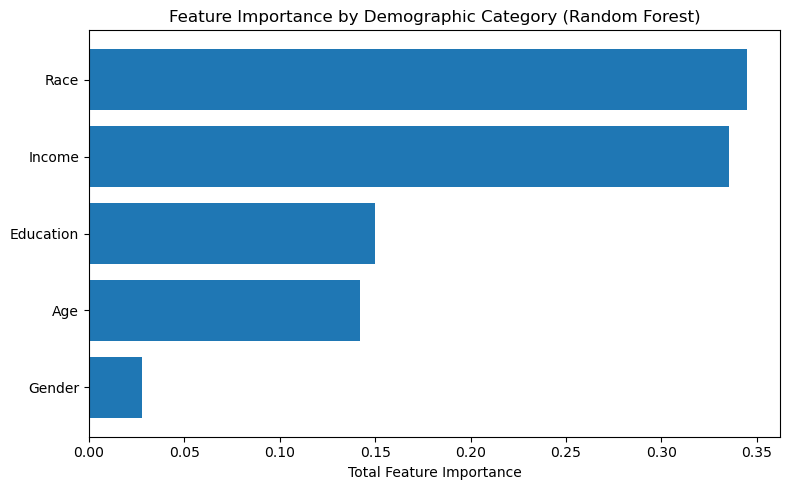

In [17]:
# Section 17: Feature Importance by Demographic Category

# filter valid features from merged_data 
features = [f for f in features if f in merged_data.columns]

# prepare data
X = merged_data[features]
y = merged_data['Age-adjusted Death Rate']

# Split and scale data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train random forest model
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# map features to categories
feature_categories = {
    # income
    'Median_Household_Income': 'Income',
    'Median_Nonfamily_Income': 'Income',
    'Median_Family_Income': 'Income',
    'Median_MarriedCouple_Income': 'Income',

    # education
    "Bachelor's degree": 'Education',
    'Graduate or professional degree': 'Education',
    'High school graduate (includes equivalency)': 'Education',
    'Less than 9th grade': 'Education',
    'Some college, no degree': 'Education',

    # age
    'Age_25 to 34 years': 'Age',
    'Age_35 to 44 years': 'Age',
    'Age_45 to 54 years': 'Age',
    'Age_55 to 59 years': 'Age',
    'Age_60 to 64 years': 'Age',
    'Age_65 to 74 years': 'Age',

    # gender
    'Gender_Male': 'Gender',
    'Gender_Female': 'Gender',

    # race
    'Race_White': 'Race',
    'Race_Black or African American': 'Race',
    'Race_Asian': 'Race',
    'Race_American Indian and Alaska Native': 'Race',
    'Race_Native Hawaiian and Other Pacific Islander': 'Race',
    'Race_Some other race': 'Race',
    'Race_Two or more races': 'Race',

}

# analyze feature importance
importances_df = pd.DataFrame({
    'Feature': features,
    'Importance': rf_model.feature_importances_
})
importances_df['Category'] = importances_df['Feature'].map(feature_categories)

# group and sort
category_importance = importances_df.groupby('Category')['Importance'].sum().reset_index()
category_importance = category_importance.sort_values('Importance', ascending=False)

# display and plot
print("\nFeature Importance by Category:")
print(category_importance)

plt.figure(figsize=(8, 5))
plt.barh(category_importance['Category'], category_importance['Importance'])
plt.xlabel('Total Feature Importance')
plt.title('Feature Importance by Demographic Category (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



Model Performance Summary:
                 Model           MSE        RMSE  R-squared
0    Linear Regression  32272.117757  179.644420   0.296699
1        Decision Tree    376.509427   19.403851   0.991795
2        Random Forest    254.922670   15.966298   0.994445
3  K-Nearest Neighbors  16427.416848  128.169485   0.642000


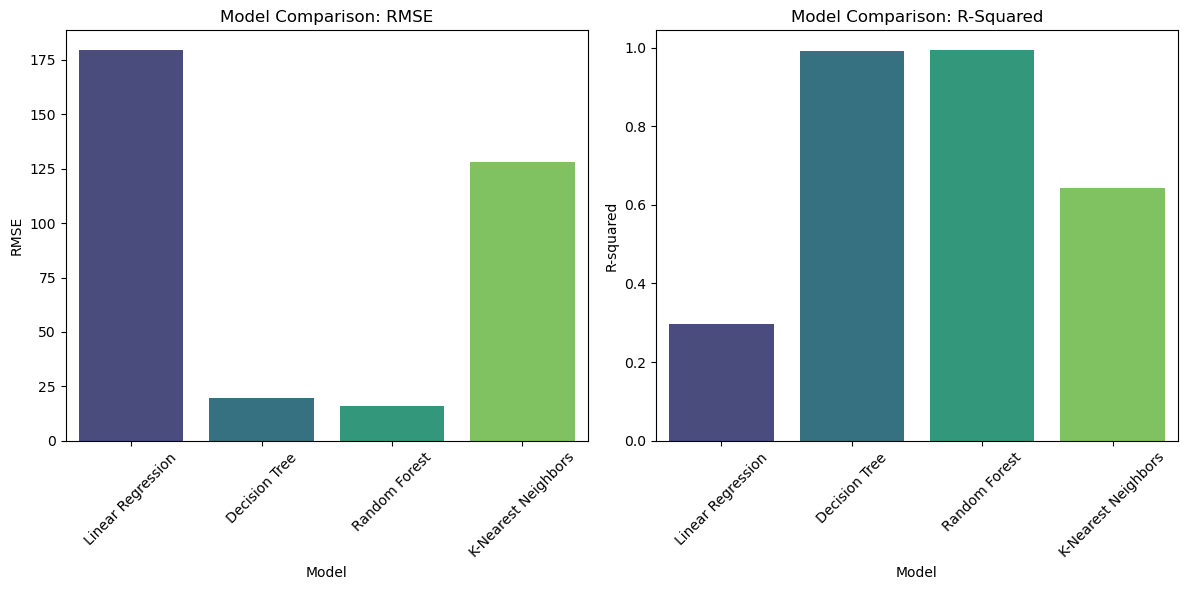

In [18]:
# Section 18: Evaluate Models and Compare Results

# display results
results_df = pd.DataFrame(results)
print("\nModel Performance Summary:")
print(results_df)

# save results to a CSV file
results_df.to_csv('model_performance_summary.csv', index=False)

# visualize model performance comparison
plt.figure(figsize=(12, 6))

# RMSE Plot
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='RMSE', data=results_df, palette='viridis')
plt.title('Model Comparison: RMSE')
plt.xticks(rotation=45)

# R-Squared Plot
plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='R-squared', data=results_df, palette='viridis')
plt.title('Model Comparison: R-Squared')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

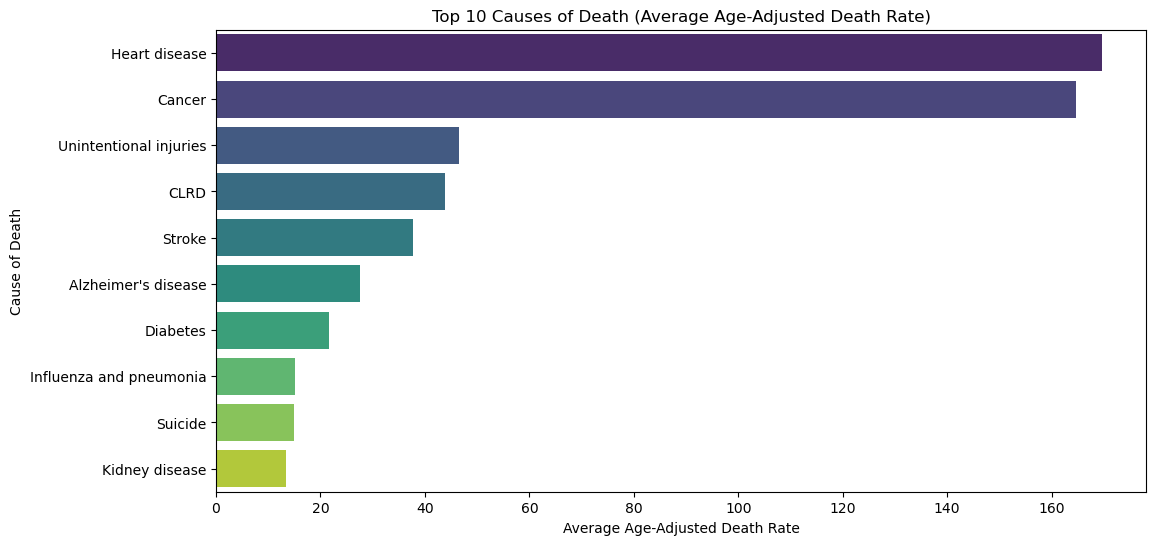

In [19]:
# Section 19: Top Causes of Death Analysis

# 'All Causes' is completely removed from the dataset
merged_data = merged_data[merged_data['Cause Name'] != 'All causes']

# group data by 'Cause Name' and calculate average Age-adjusted Death Rate
top_causes = merged_data.groupby('Cause Name')['Age-adjusted Death Rate'].mean().sort_values(ascending=False).head(10)

# plot top causes of death
plt.figure(figsize=(12, 6))
sns.barplot(x=top_causes.values, y=top_causes.index, palette='viridis')
plt.title('Top 10 Causes of Death (Average Age-Adjusted Death Rate)')
plt.xlabel('Average Age-Adjusted Death Rate')
plt.ylabel('Cause of Death')
plt.show()

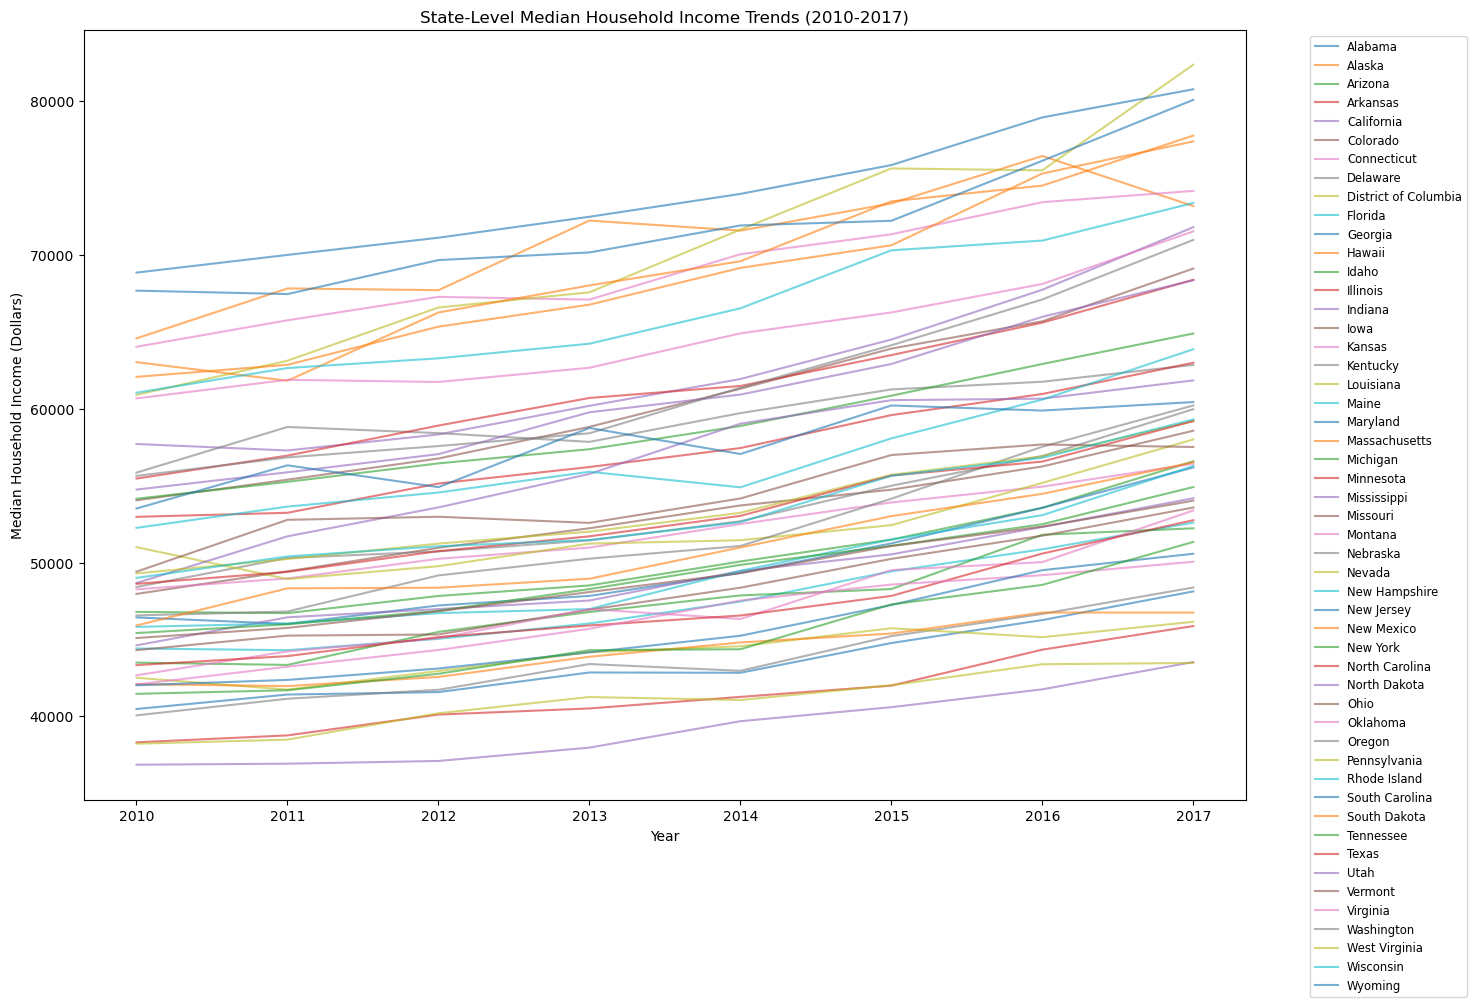

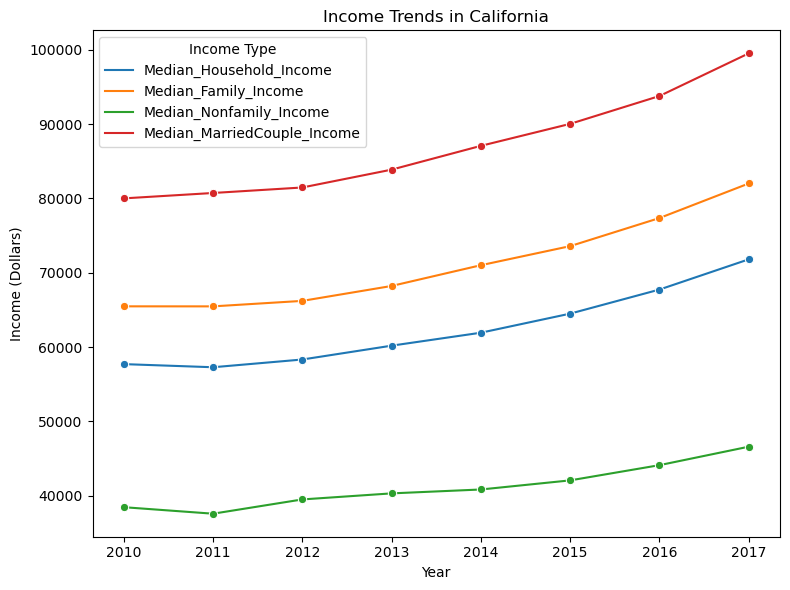

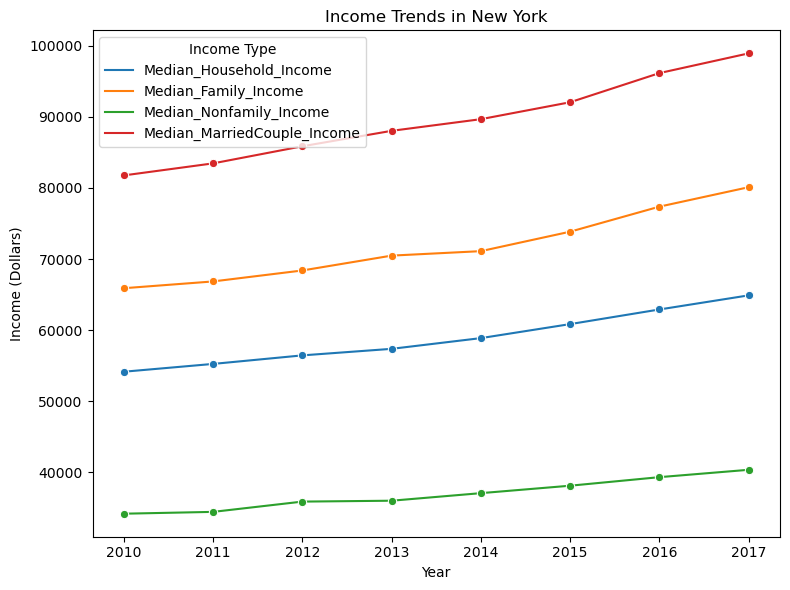

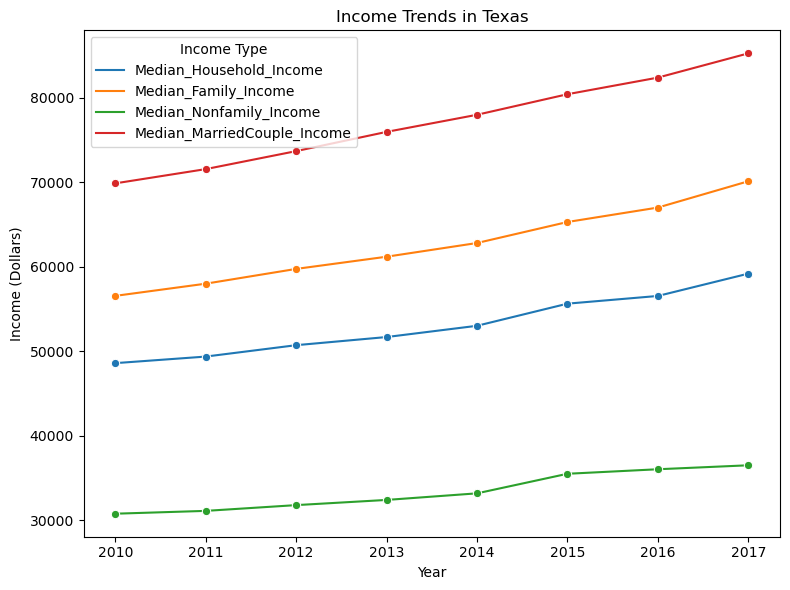

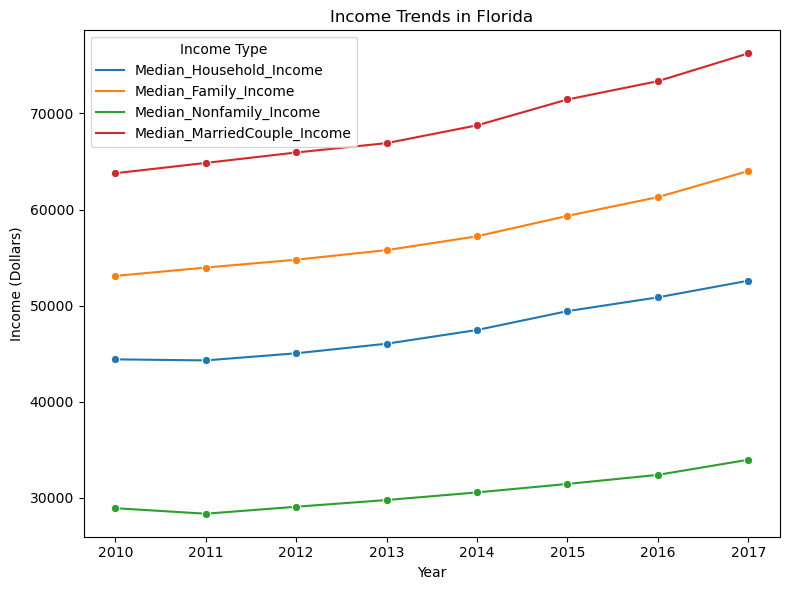

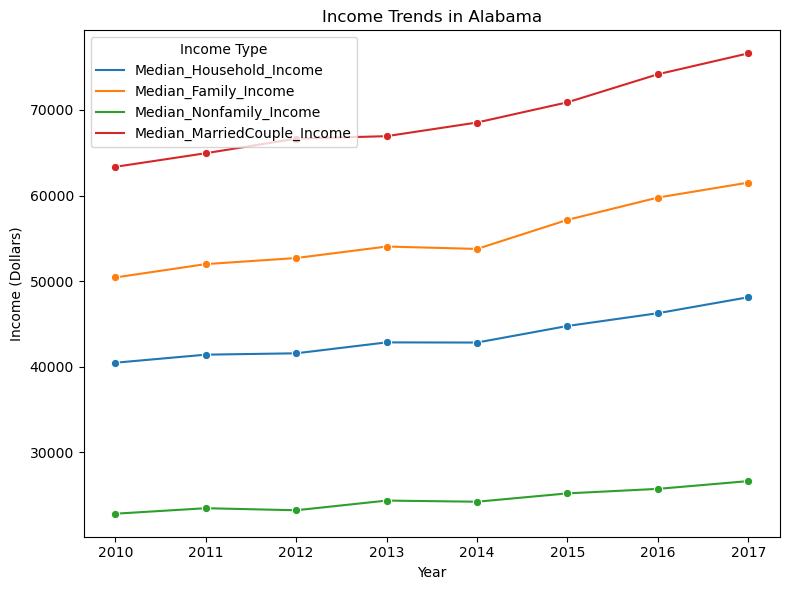

In [20]:
# Section 20: State-Level Income Trends

# remove 'All Causes' from the data
filtered_data = merged_data[merged_data['Cause Name'] != 'All Causes']

# plot Median Household Income by state (2010-2017)
plt.figure(figsize=(15, 10))
for state in filtered_data['State'].unique():
    state_data = filtered_data[filtered_data['State'] == state]
    plt.plot(state_data['Year'], state_data['Median_Household_Income'], label=state, alpha=0.6)

plt.title('State-Level Median Household Income Trends (2010-2017)')
plt.xlabel('Year')
plt.ylabel('Median Household Income (Dollars)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.show()


# recreating state_income by grouping income data at the state and year level
state_income = income_data_filtered.groupby(['State', 'Year']).agg({
    'Median_Household_Income': 'mean',
    'Median_Family_Income': 'mean',
    'Median_Nonfamily_Income': 'mean',
    'Median_MarriedCouple_Income': 'mean'
}).reset_index()


# melting income data for plotting
income_long = state_income.melt(
    id_vars=['State', 'Year'],
    value_vars=[
        'Median_Household_Income',
        'Median_Family_Income',
        'Median_Nonfamily_Income',
        'Median_MarriedCouple_Income'
    ],
    var_name='Income_Type',
    value_name='Income'
)

# define states to visualize
states_to_plot = ['California', 'New York', 'Texas', 'Florida', 'Alabama']


for state in states_to_plot:
    plt.figure(figsize=(8, 6))
    data = income_long[income_long['State'] == state]
    sns.lineplot(data=data, x='Year', y='Income', hue='Income_Type', marker='o')
    plt.title(f'Income Trends in {state}')
    plt.xlabel('Year')
    plt.ylabel('Income (Dollars)')
    plt.legend(title='Income Type')
    plt.tight_layout()
    plt.show()


Top Causes of Death:
['Heart disease', 'Cancer', 'CLRD', 'Unintentional injuries', 'Stroke']


/var/folders/pm/svmkc_hn0gx06d71pj8lw4080000gn/T/ipykernel_89487/411123609.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_causes_data['Death_Proportion'] = (


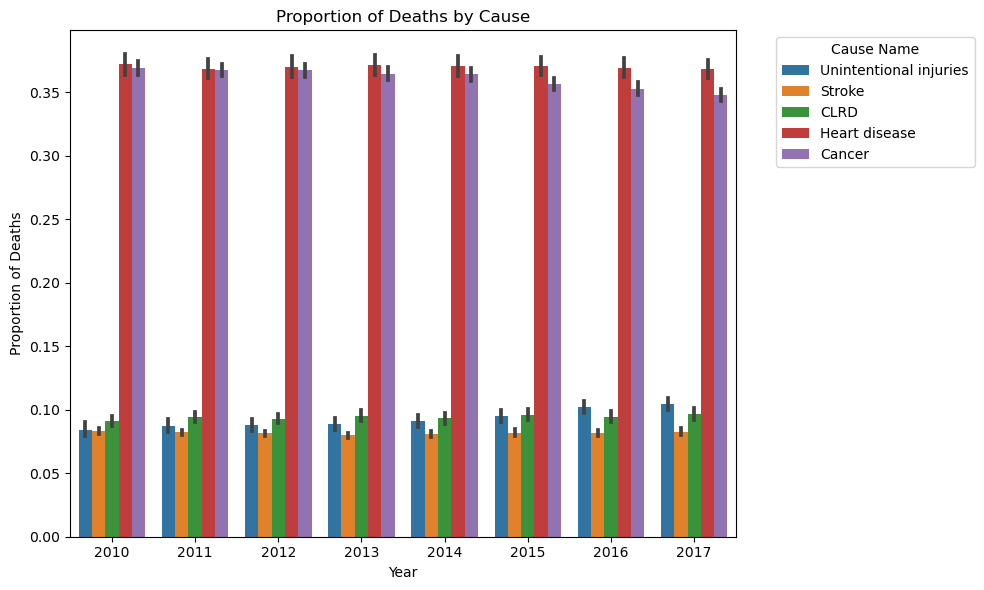

In [21]:
# Section 21: Top Causes of Death Analysis

# calculate total deaths per cause
cause_totals = filtered_data.groupby('Cause Name')['Deaths'].sum().reset_index()

# identify top 5 causes
top_causes = cause_totals.sort_values(by='Deaths', ascending=False).head(5)['Cause Name'].tolist()
print("\nTop Causes of Death:")
print(top_causes)

# analyze top causes
top_causes_data = filtered_data[filtered_data['Cause Name'].isin(top_causes)]
top_causes_data['Death_Proportion'] = (
    top_causes_data['Deaths'] / 
    top_causes_data.groupby(['State', 'Year'])['Deaths'].transform('sum')
)

# visualize proportions
plt.figure(figsize=(10, 6))
sns.barplot(data=top_causes_data, x='Year', y='Death_Proportion', hue='Cause Name')
plt.title('Proportion of Deaths by Cause')
plt.xlabel('Year')
plt.ylabel('Proportion of Deaths')
plt.legend(title='Cause Name', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


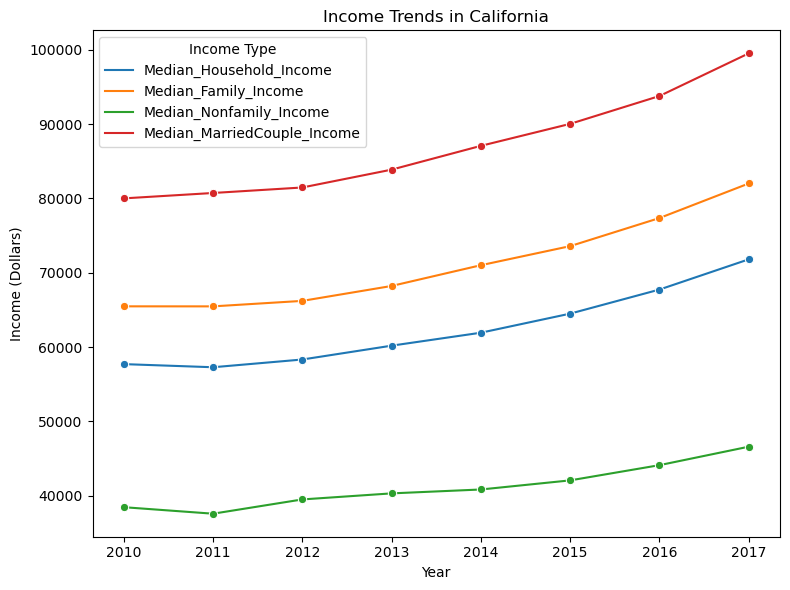

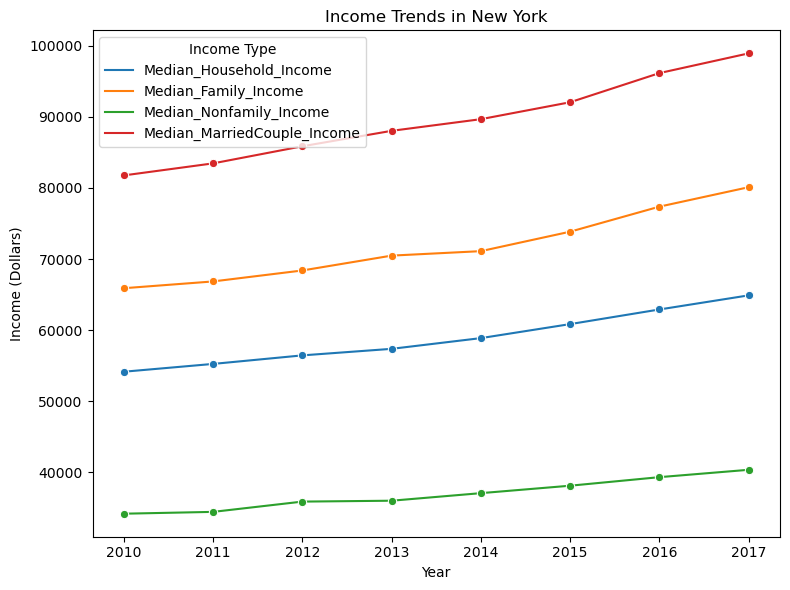

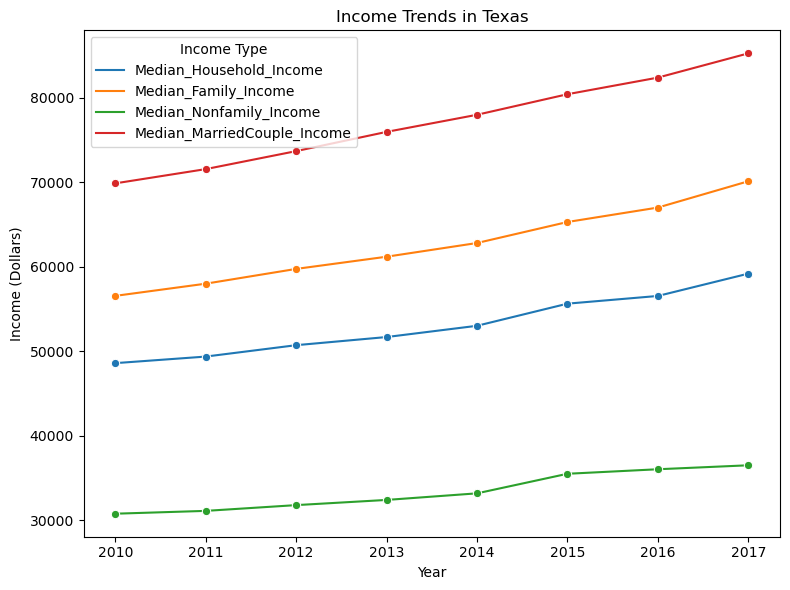

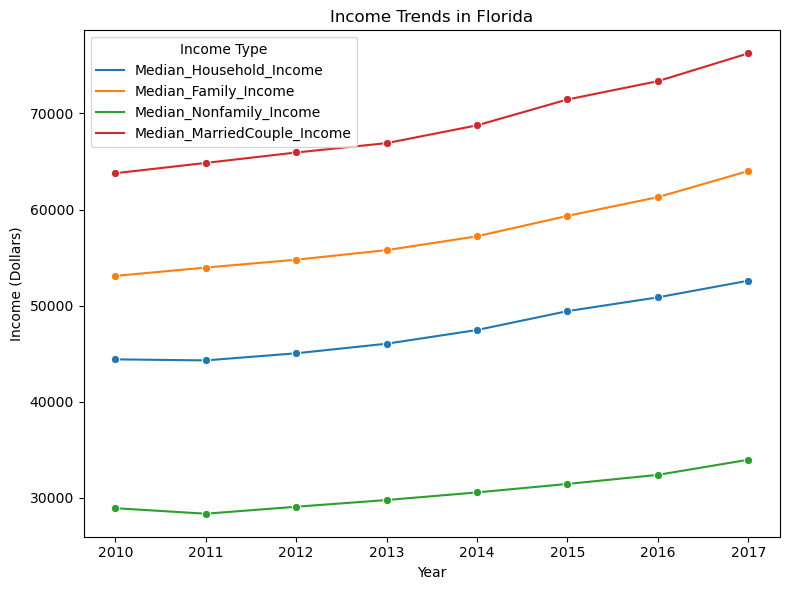

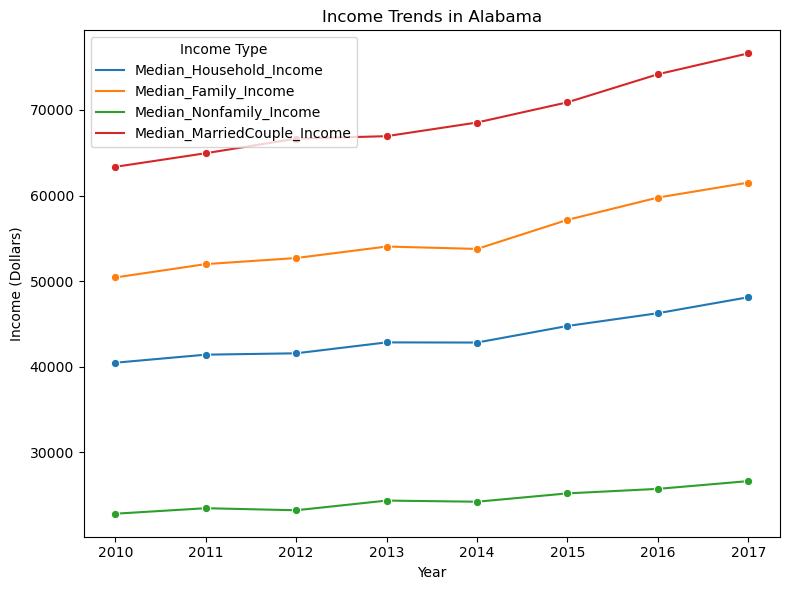

In [22]:
# Section 21: State-Level Income Trends
# create state income summary
state_income = income_data_filtered.groupby(['State', 'Year']).agg({
    'Median_Household_Income': 'mean',
    'Median_Family_Income': 'mean',
    'Median_Nonfamily_Income': 'mean',
    'Median_MarriedCouple_Income': 'mean'
}).reset_index()

# melt for plotting
income_long = state_income.melt(
    id_vars=['State', 'Year'],
    value_vars=[
        'Median_Household_Income',
        'Median_Family_Income',
        'Median_Nonfamily_Income',
        'Median_MarriedCouple_Income'
    ],
    var_name='Income_Type',
    value_name='Income'
)

# plot for selected states
states_to_plot = ['California', 'New York', 'Texas', 'Florida', 'Alabama']

for state in states_to_plot:
    plt.figure(figsize=(8, 6))
    data = income_long[income_long['State'] == state]
    sns.lineplot(data=data, x='Year', y='Income', hue='Income_Type', marker='o')
    plt.title(f'Income Trends in {state}')
    plt.xlabel('Year')
    plt.ylabel('Income (Dollars)')
    plt.legend(title='Income Type')
    plt.tight_layout()
    plt.show()

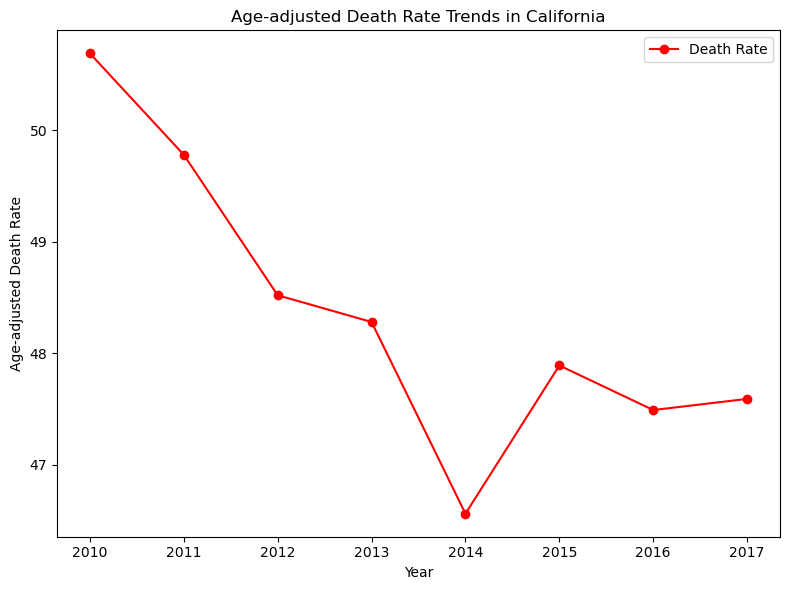

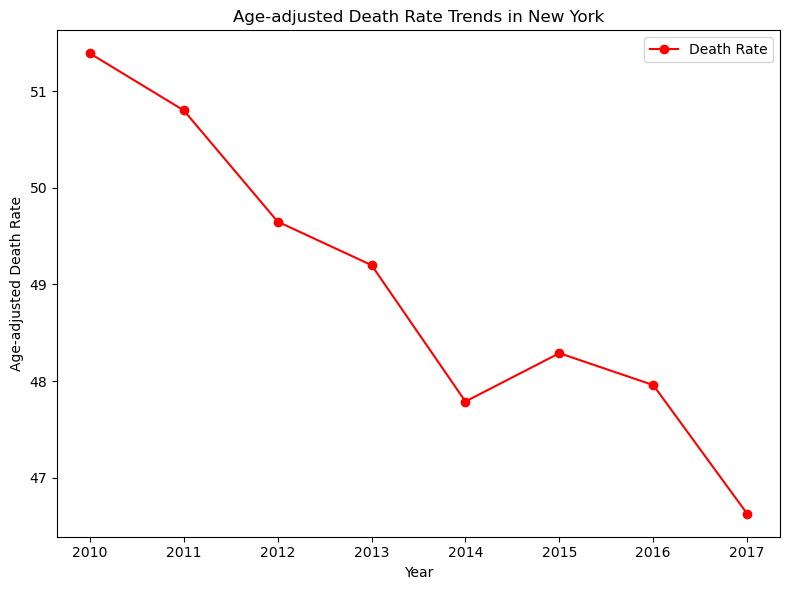

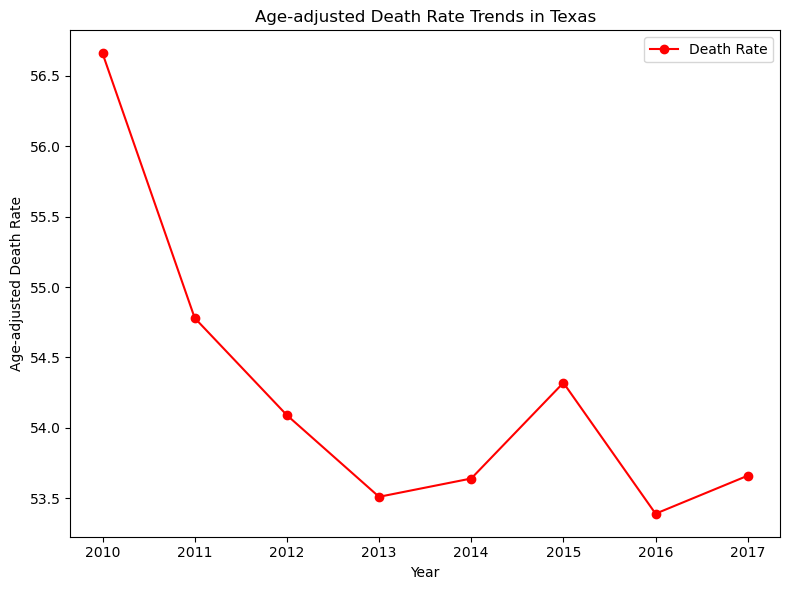

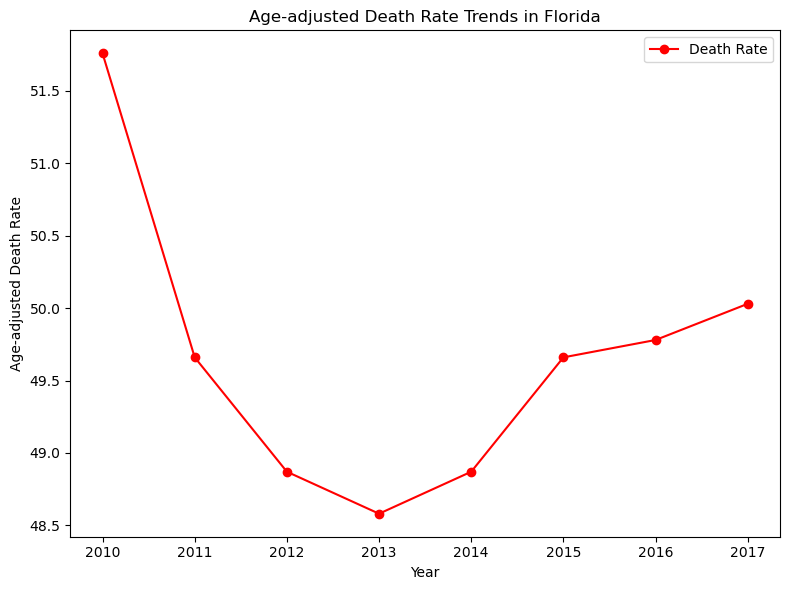

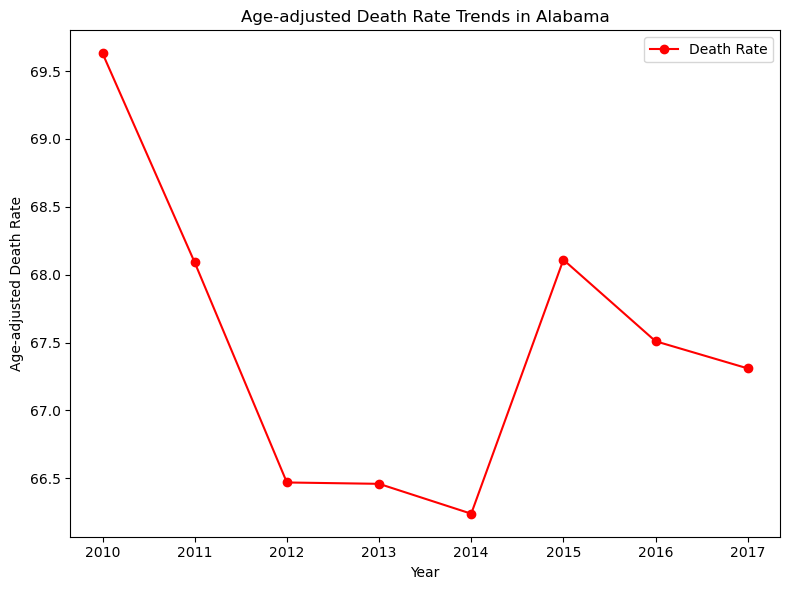

In [23]:
# Section 22: Death Rate Trends Across States
# calculate state mortality metrics
state_mortality = merged_data.groupby(['State', 'Year']).agg({
    'Age-adjusted Death Rate': 'mean',
    'Deaths': 'sum'
}).reset_index()

# plot trends for selected states
for state in states_to_plot:
    plt.figure(figsize=(8, 6))
    state_subset = state_mortality[state_mortality['State'] == state]
    plt.plot(state_subset['Year'], state_subset['Age-adjusted Death Rate'], marker='o', label='Death Rate', color='red')
    plt.title(f'Age-adjusted Death Rate Trends in {state}')
    plt.xlabel('Year')
    plt.ylabel('Age-adjusted Death Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()



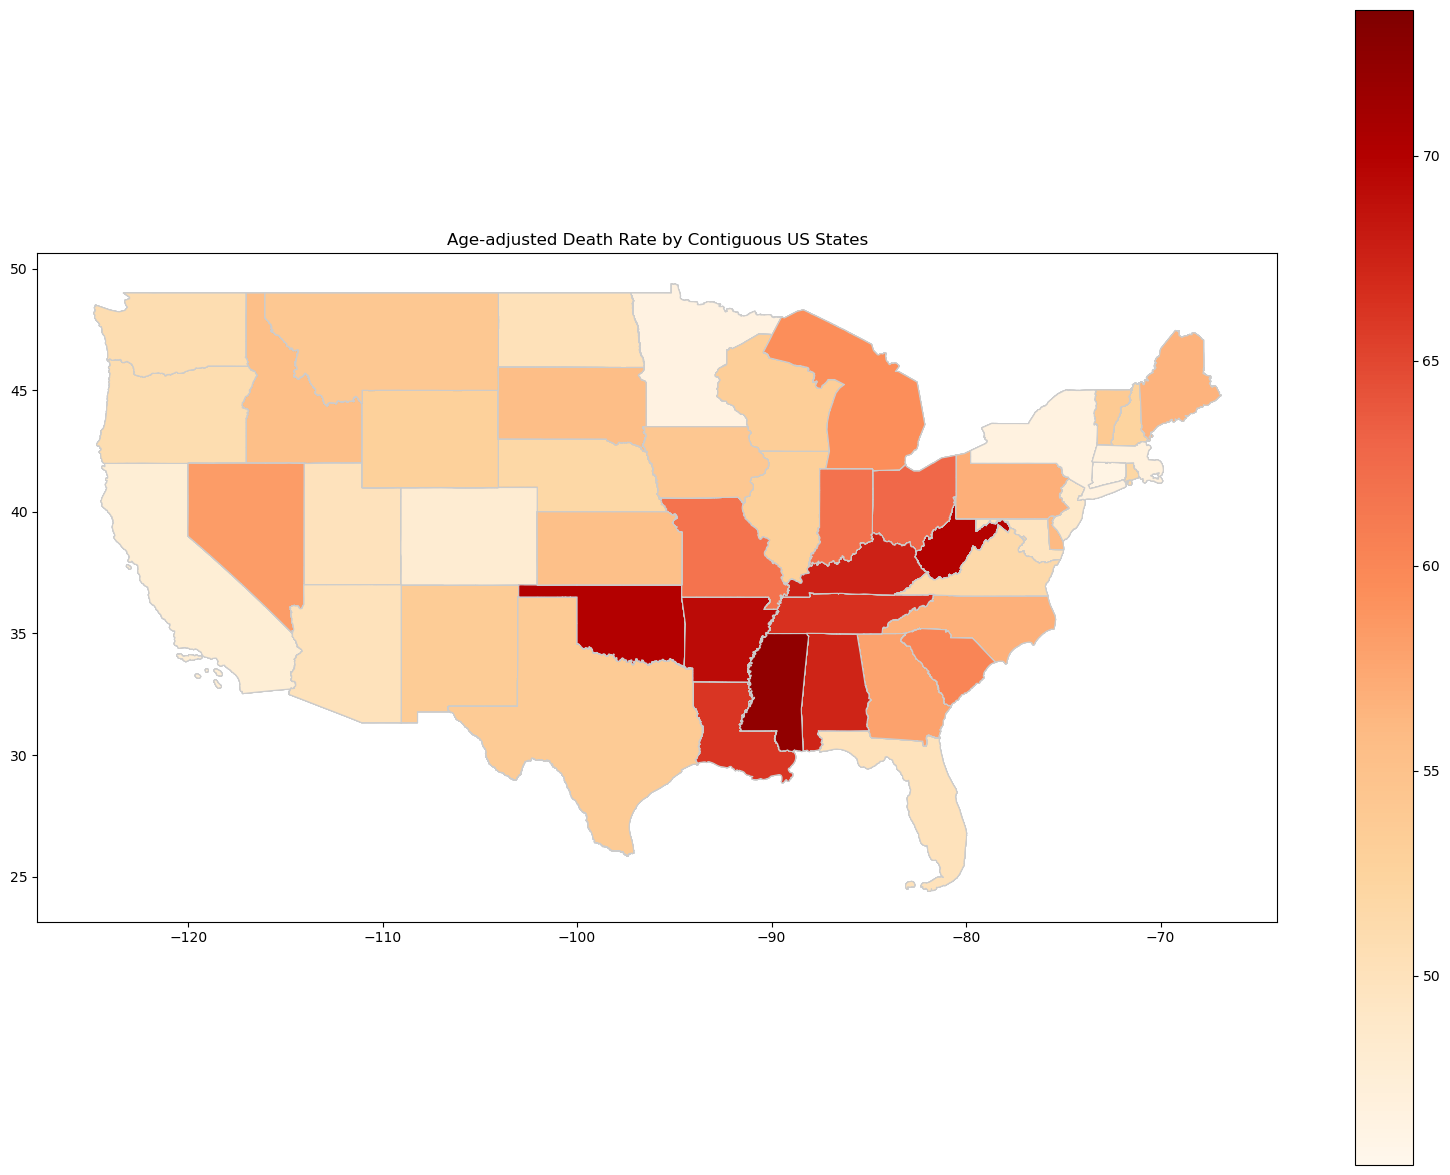

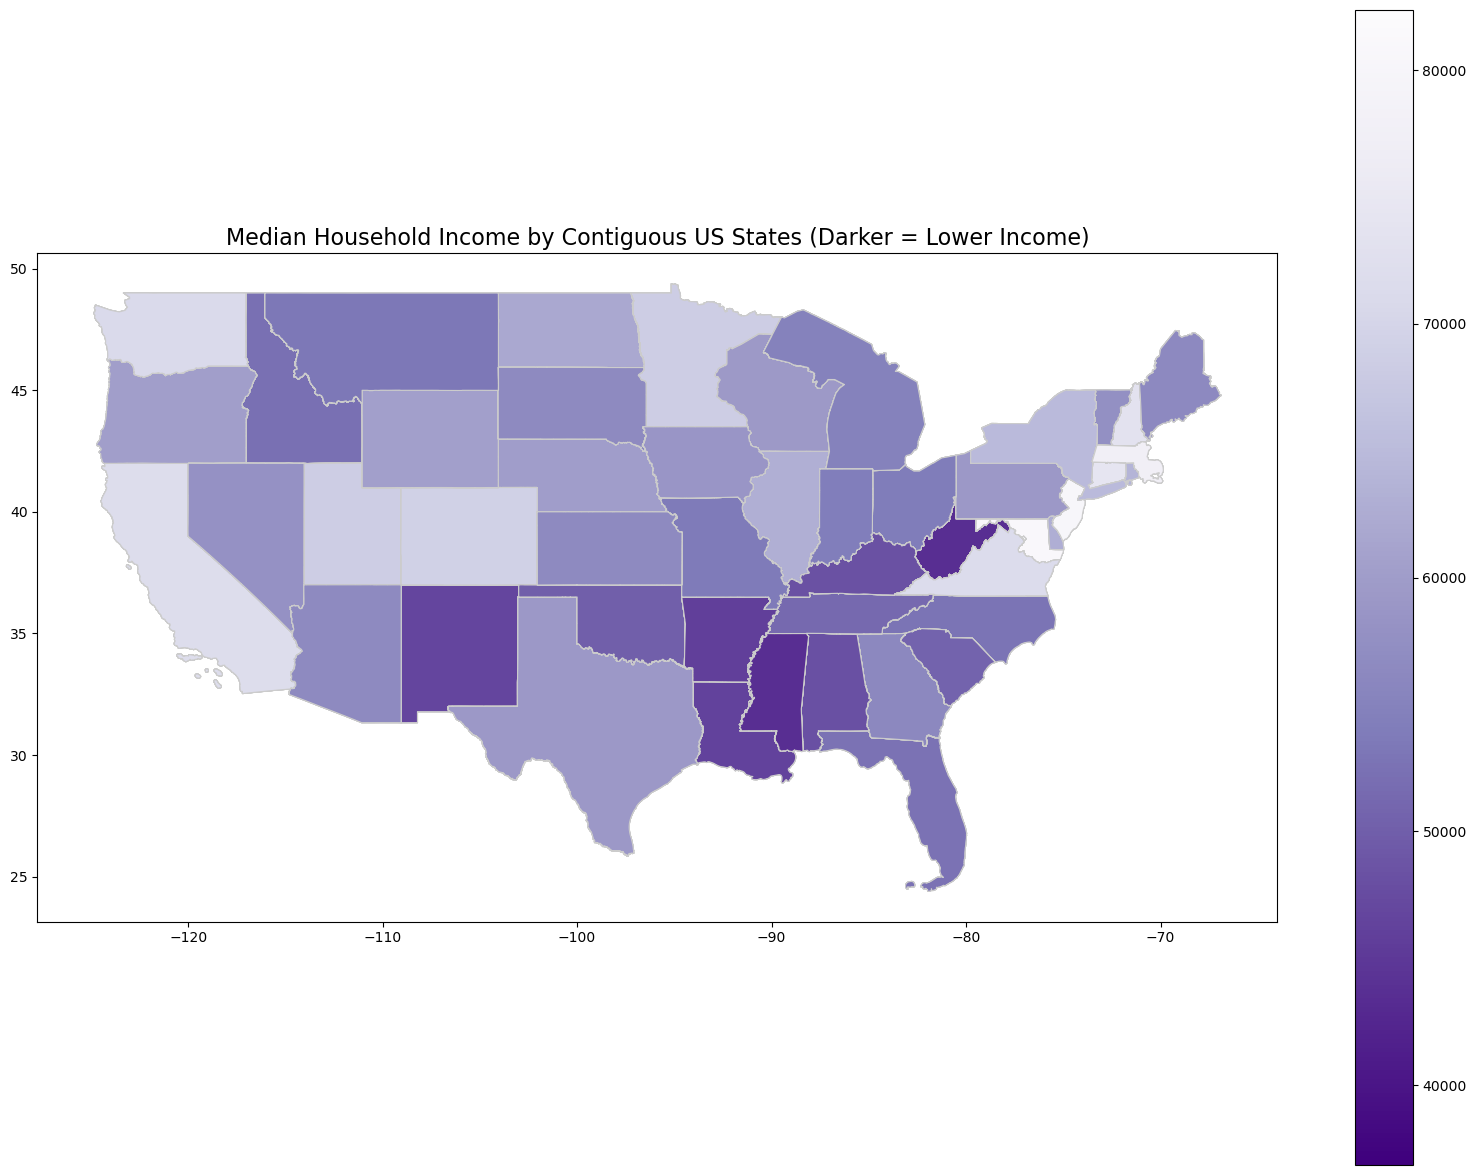

In [24]:
# Section 23: Geographic Visualization
# load shapefile
shapefile_path = "tl_2024_us_state.shp"
states_shapefile = gpd.read_file(shapefile_path)

# merge with state data
state_data = pd.merge(
    state_income,
    state_mortality,
    on=['State', 'Year'],
    how='inner'
)

state_data.rename(columns={"State": "NAME"}, inplace=True)
states_geo = states_shapefile.merge(
    state_data,
    on='NAME',  
    how='left'
)

# filter for contiguous US
contiguous_states = states_geo[~states_geo['STUSPS'].isin(['HI', 'AK', 'PR', 'GU', 'VI', 'MP', 'AS'])]

# plot death rate by state
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
contiguous_states.plot(
    column='Age-adjusted Death Rate',
    cmap='OrRd',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True
)
plt.title('Age-adjusted Death Rate by Contiguous US States')
plt.show()

# plot income by state
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
contiguous_states.plot(
    column='Median_Household_Income',  
    cmap='Purples_r', 
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True
)
plt.title('Median Household Income by Contiguous US States (Darker = Lower Income)', fontsize=16)
plt.show()


/var/folders/pm/svmkc_hn0gx06d71pj8lw4080000gn/T/ipykernel_89487/319080431.py:6: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(states_geo)
/Users/somaezzadpanah/anaconda3/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
 There are 5 islands with ids: 272, 273, 274, 307, 364.
  W.__init__(self, neighbors, ids=ids, **kw)


('WARNING: ', 272, ' is an island (no neighbors)')
('WARNING: ', 273, ' is an island (no neighbors)')
('WARNING: ', 274, ' is an island (no neighbors)')
('WARNING: ', 307, ' is an island (no neighbors)')
('WARNING: ', 364, ' is an island (no neighbors)')

Moran's I: nan, p-value: 0.001


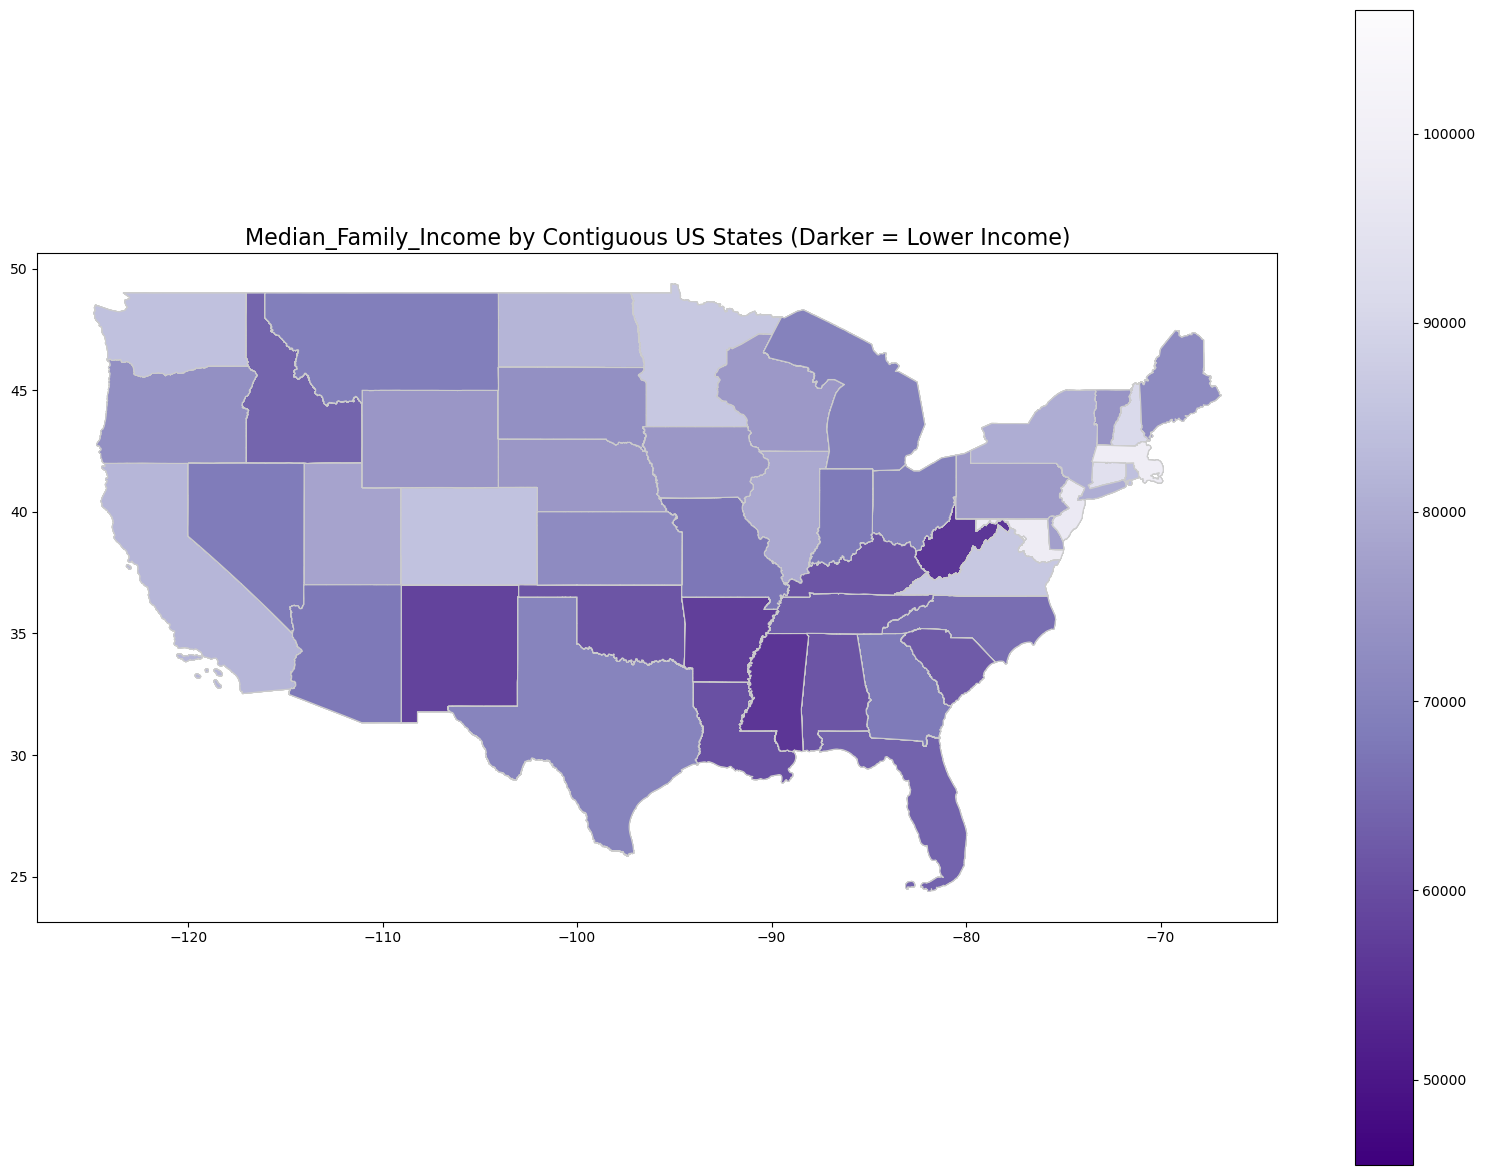

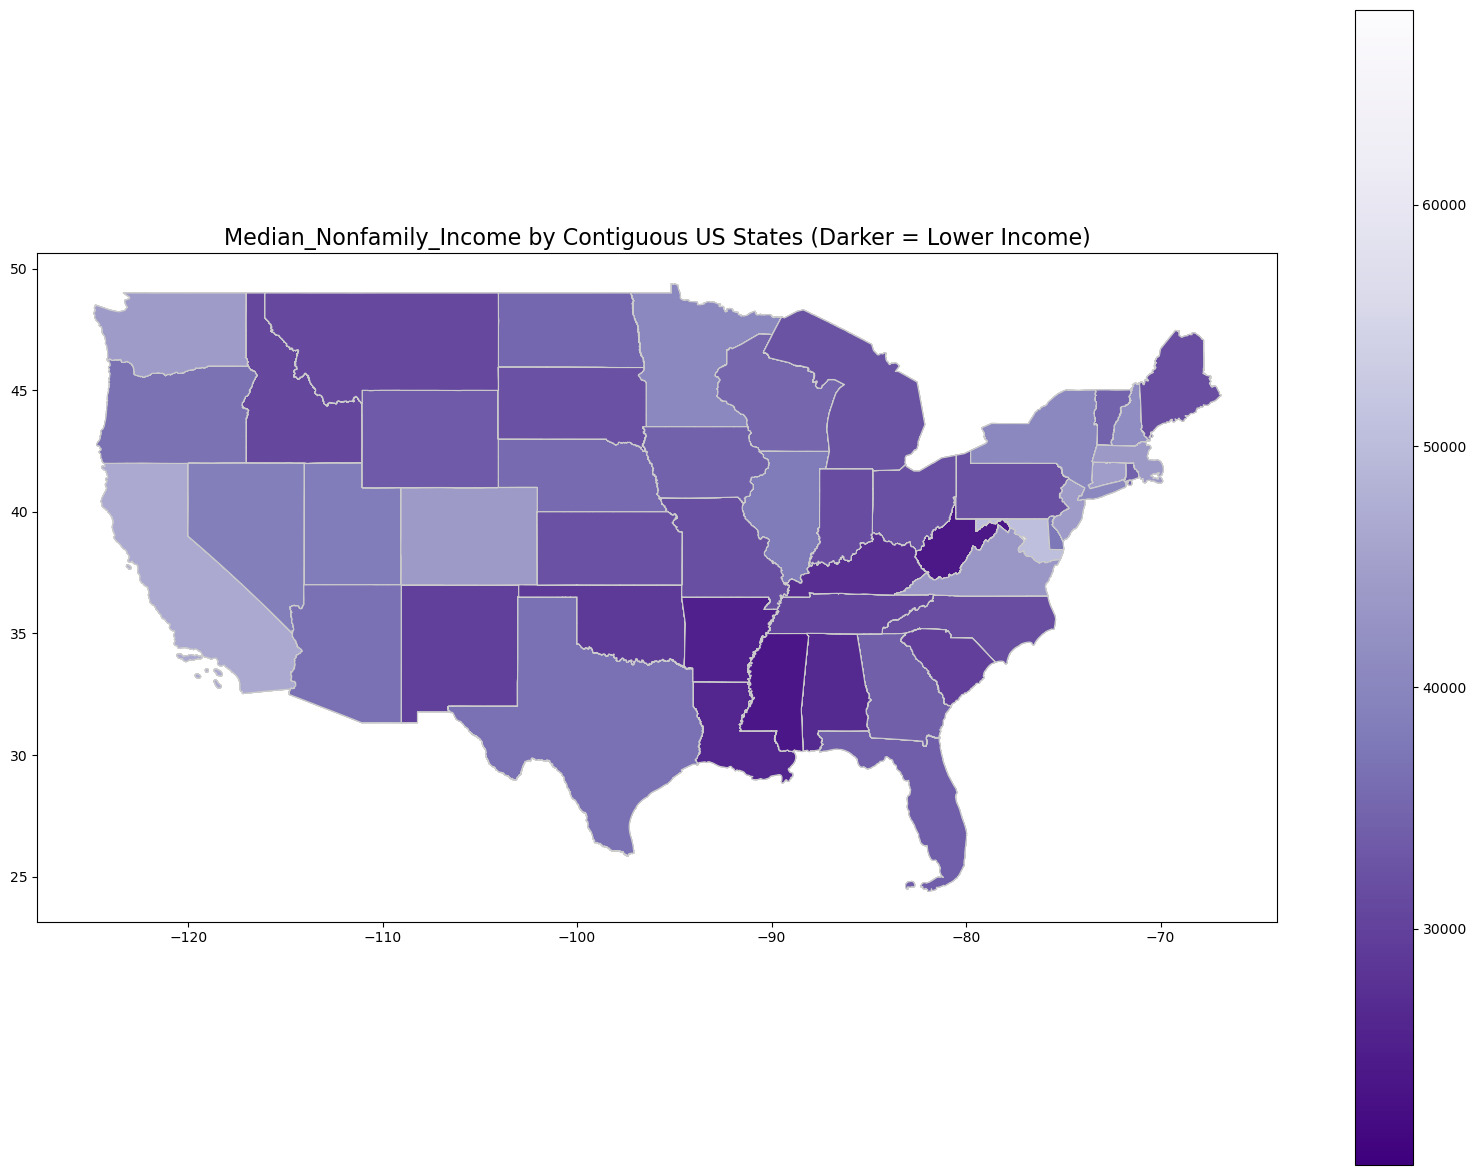

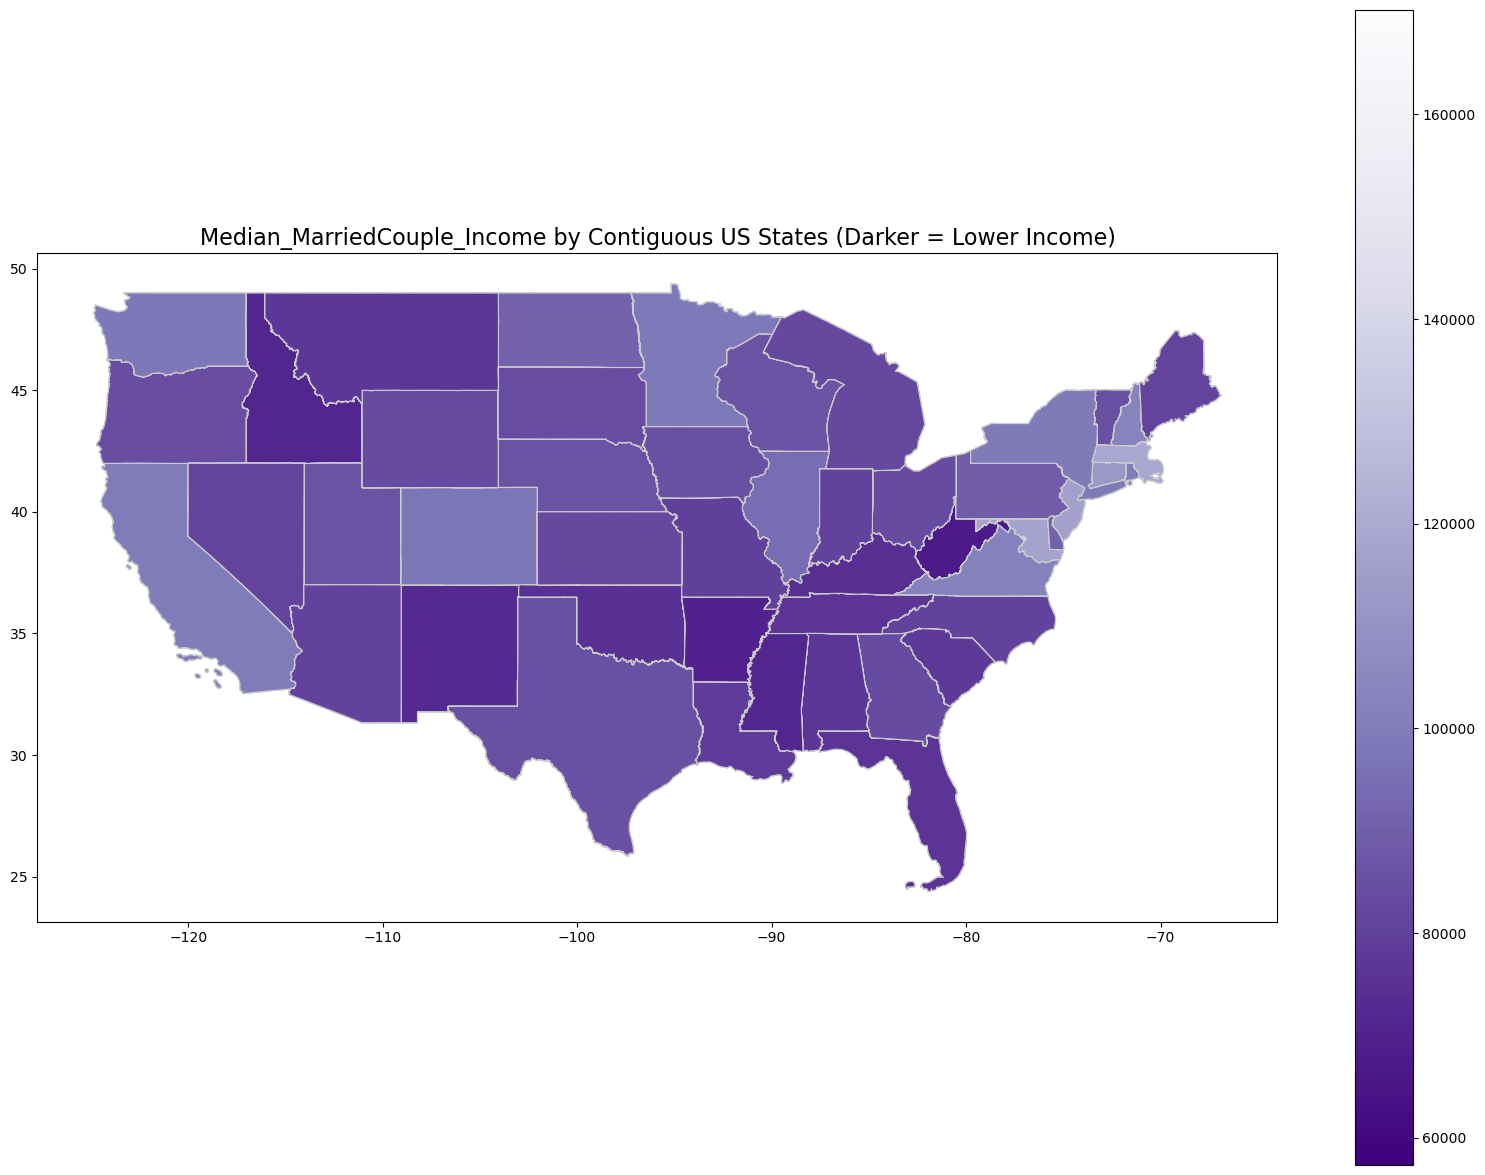

In [25]:
# Section 24: Spatial Autocorrelation Analysis
# convert to appropriate CRS
states_geo = states_geo.to_crs(epsg=5070)

# create weights matrix
w = Queen.from_dataframe(states_geo)

# calculate Moran's I
moran = Moran(states_geo['Age-adjusted Death Rate'], w)
print(f"\nMoran's I: {moran.I}, p-value: {moran.p_sim}")
income_columns = [
    'Median_Family_Income',
    'Median_Nonfamily_Income',
    'Median_MarriedCouple_Income'
]

for income_col in income_columns:
    fig, ax = plt.subplots(1, 1, figsize=(20, 15))
    contiguous_states.plot(
        column=income_col,
        cmap='Purples_r',
        linewidth=0.8,
        ax=ax,
        edgecolor='0.8',
        legend=True
    )
    plt.title(f'{income_col} by Contiguous US States (Darker = Lower Income)', fontsize=16)
    plt.show()


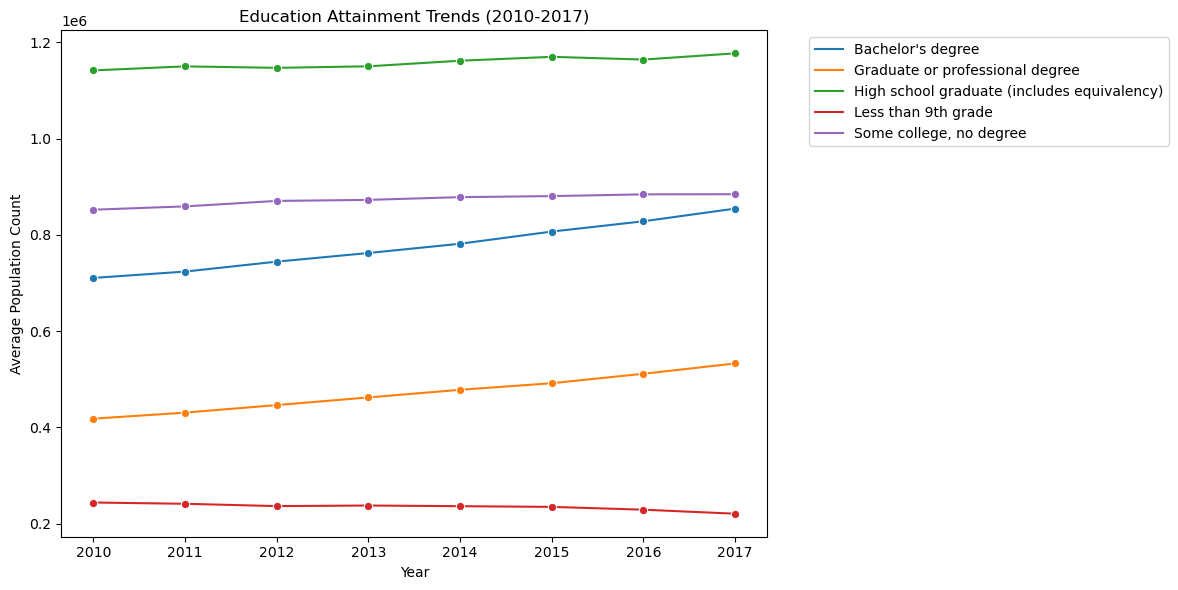

In [26]:
# Section 25: Education Attainment Visualization
# calculate education proportions
education_proportions = merged_data.groupby('Year').agg({
    "Bachelor's degree": 'mean',
    'Graduate or professional degree': 'mean',
    'High school graduate (includes equivalency)': 'mean',
    'Less than 9th grade': 'mean',
    'Some college, no degree': 'mean'
}).reset_index()

# melt for plotting
edu_long = education_proportions.melt(
    id_vars='Year',
    var_name='Education Level',
    value_name='Population Count'
)

# plot education trends
plt.figure(figsize=(12, 6))
sns.lineplot(
    data=edu_long,
    x='Year',
    y='Population Count',
    hue='Education Level',
    marker='o'
)
plt.title('Education Attainment Trends (2010-2017)')
plt.ylabel('Average Population Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

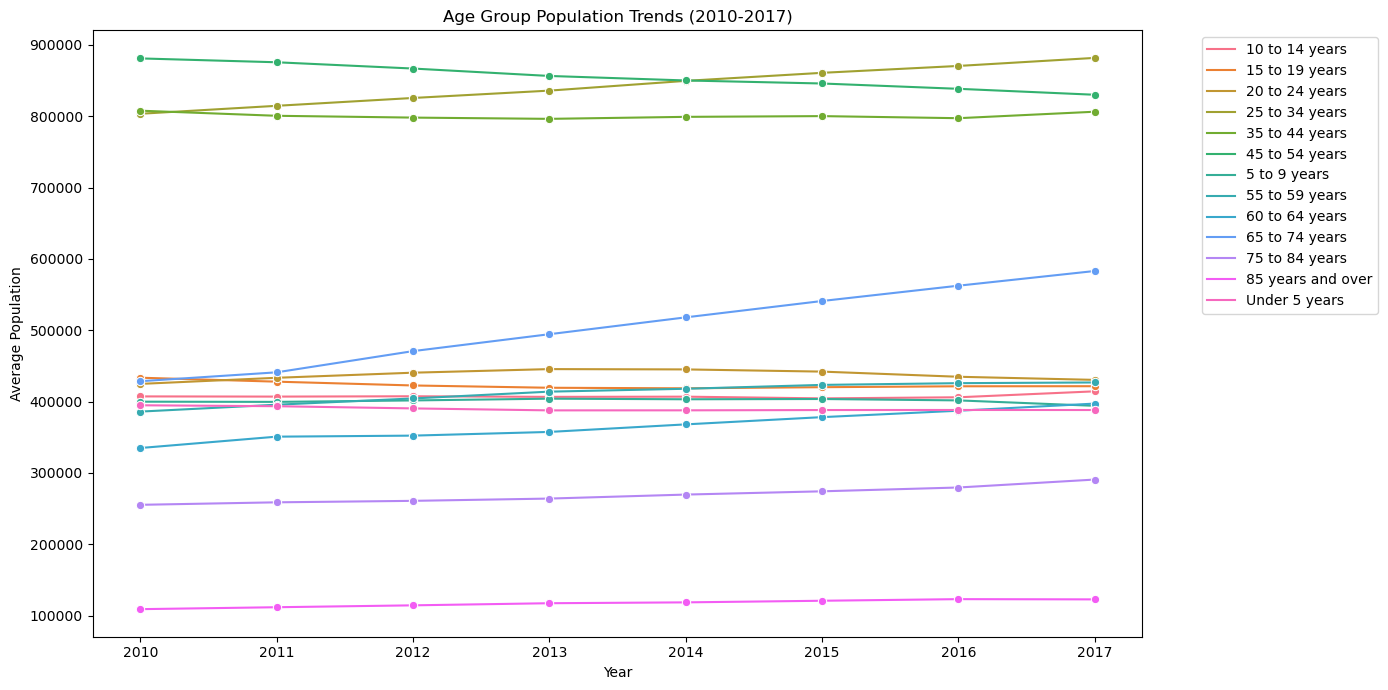

In [27]:
# Section 26: Age Distribution Visualization
# calculate age group proportions
age_columns = [col for col in merged_data.columns if col.startswith('Age_')]
age_proportions = merged_data.groupby('Year')[age_columns].mean().reset_index()

# melt for plotting
age_long = age_proportions.melt(
    id_vars='Year',
    var_name='Age Group',
    value_name='Population'
)

# clean age group names
age_long['Age Group'] = age_long['Age Group'].str.replace('Age_', '')

# plot age distribution trends
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=age_long,
    x='Year',
    y='Population',
    hue='Age Group',
    marker='o'
)
plt.title('Age Group Population Trends (2010-2017)')
plt.ylabel('Average Population')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

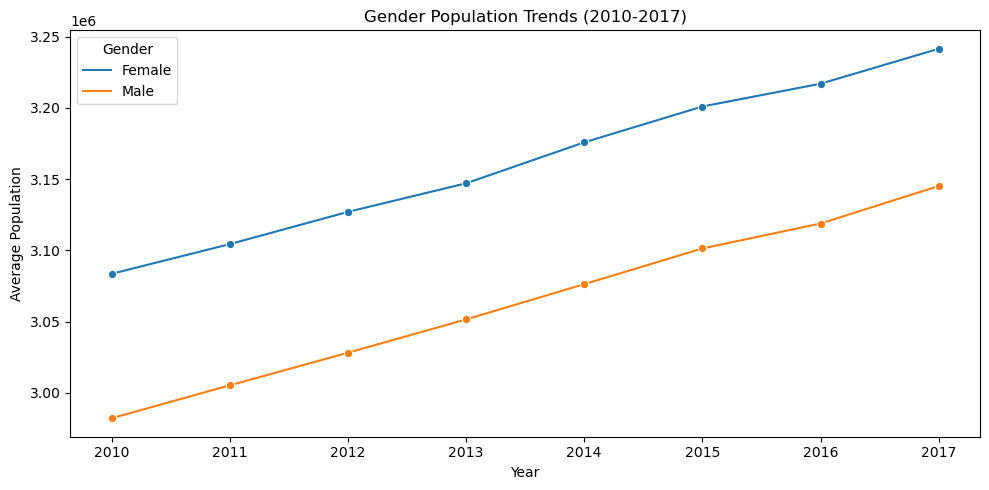

In [28]:
# Section 27: Gender Distribution Visualization
# calculate gender proportions
gender_proportions = merged_data.groupby('Year').agg({
    'Gender_Female': 'mean',
    'Gender_Male': 'mean'
}).reset_index()

# melt for plotting
gender_long = gender_proportions.melt(
    id_vars='Year',
    var_name='Gender',
    value_name='Population'
)

# clean gender names
gender_long['Gender'] = gender_long['Gender'].str.replace('Gender_', '')

# plot gender trends
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=gender_long,
    x='Year',
    y='Population',
    hue='Gender',
    marker='o'
)
plt.title('Gender Population Trends (2010-2017)')
plt.ylabel('Average Population')
plt.tight_layout()
plt.show()


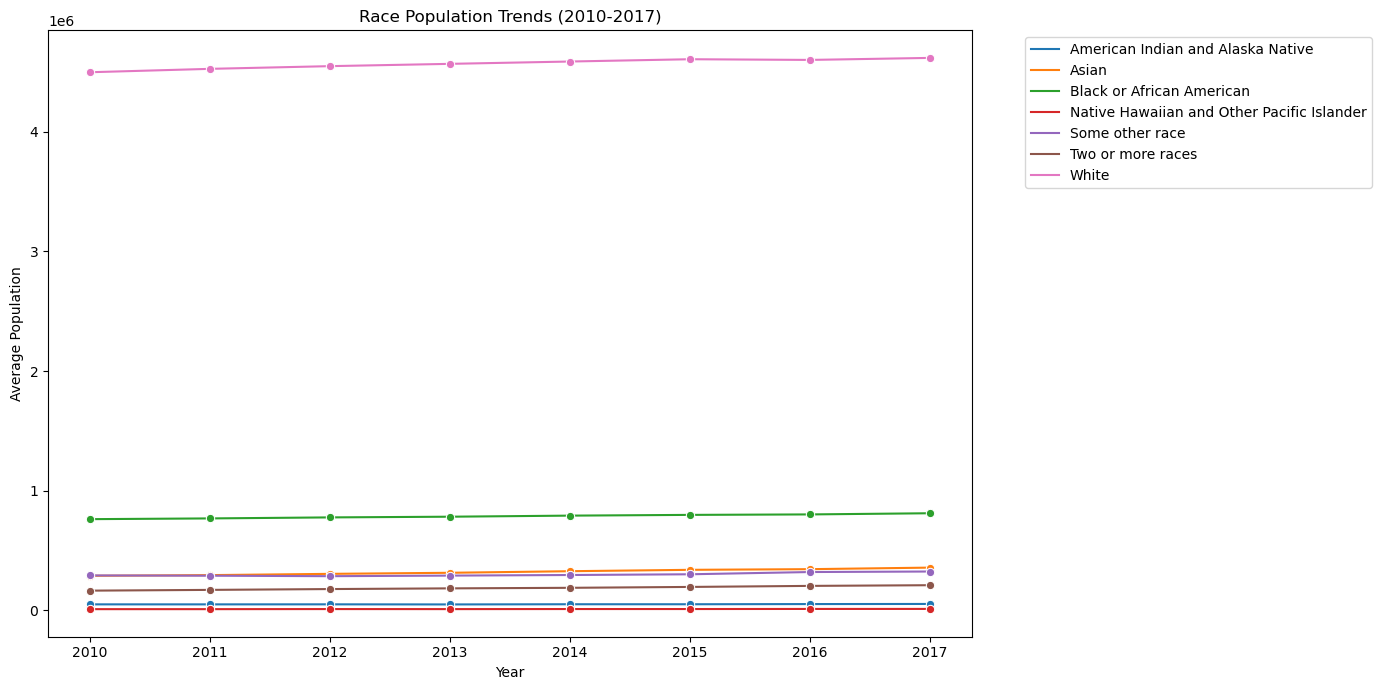

In [29]:
# Section 28: Race Distribution Visualization
# calculate race proportions
race_columns = [col for col in merged_data.columns if col.startswith('Race_')]
race_proportions = merged_data.groupby('Year')[race_columns].mean().reset_index()

# melt for plotting
race_long = race_proportions.melt(
    id_vars='Year',
    var_name='Race',
    value_name='Population'
)

# clean race names
race_long['Race'] = race_long['Race'].str.replace('Race_', '')

# plot race distribution
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=race_long,
    x='Year',
    y='Population',
    hue='Race',
    marker='o'
)
plt.title('Race Population Trends (2010-2017)')
plt.ylabel('Average Population')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

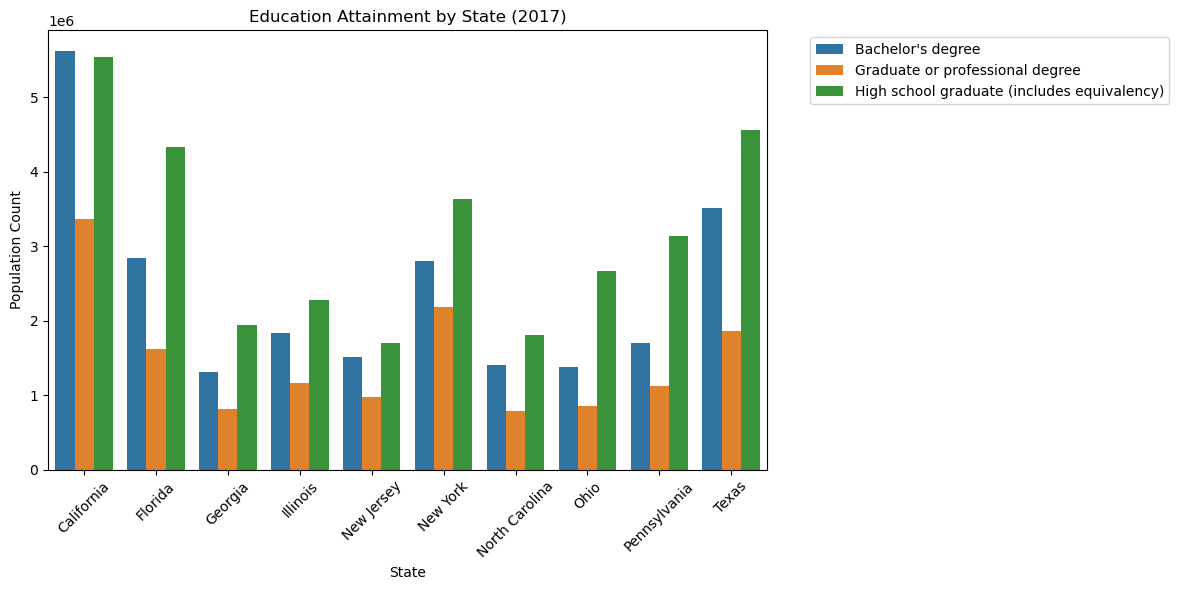

In [30]:
# Section 29: State-Level Education Comparison
# get most recent year's data
latest_year = merged_data['Year'].max()
latest_education = merged_data[merged_data['Year'] == latest_year]

# select top 10 states by bachelor's degree attainment
top_education_states = latest_education.groupby('State')["Bachelor's degree"].mean().nlargest(10).index

# filter and melt data
edu_state_long = latest_education[latest_education['State'].isin(top_education_states)].melt(
    id_vars=['State'],
    value_vars=[
        "Bachelor's degree",
        'Graduate or professional degree',
        'High school graduate (includes equivalency)'
    ],
    var_name='Education Level',
    value_name='Population'
)

# plot state education comparison
plt.figure(figsize=(12, 6))
sns.barplot(
    data=edu_state_long,
    x='State',
    y='Population',
    hue='Education Level'
)
plt.title(f'Education Attainment by State ({latest_year})')
plt.ylabel('Population Count')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


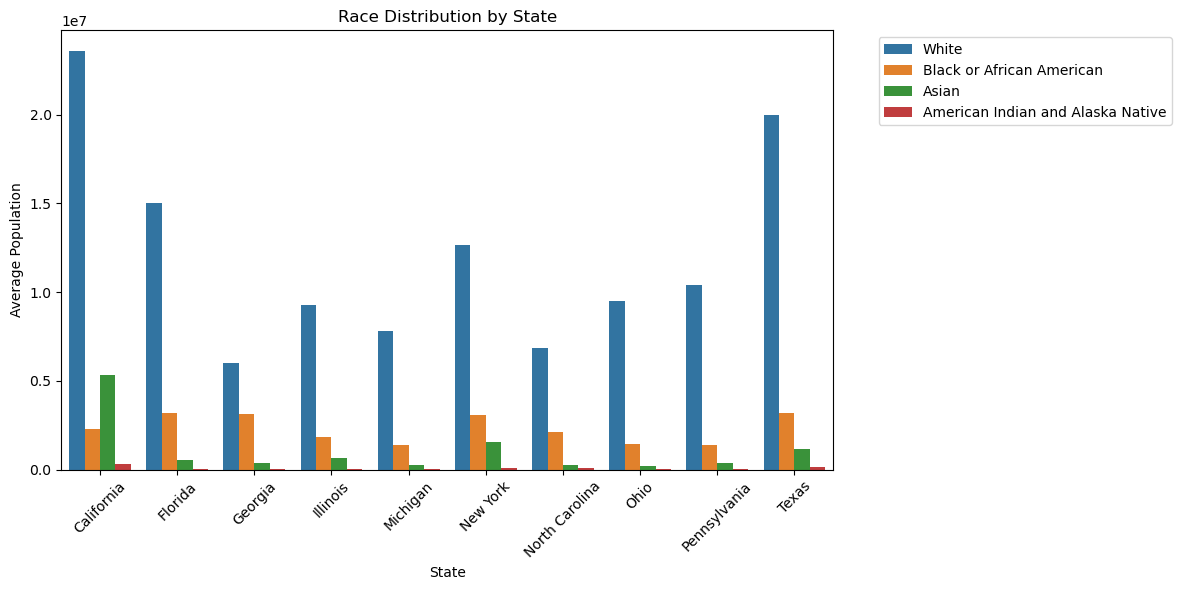

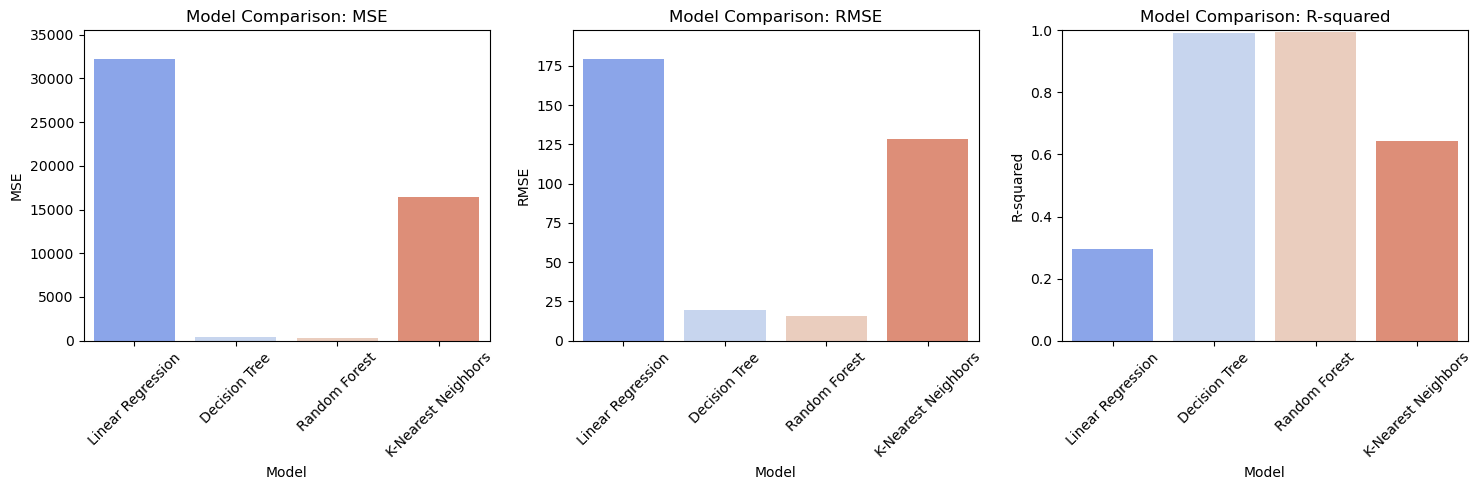

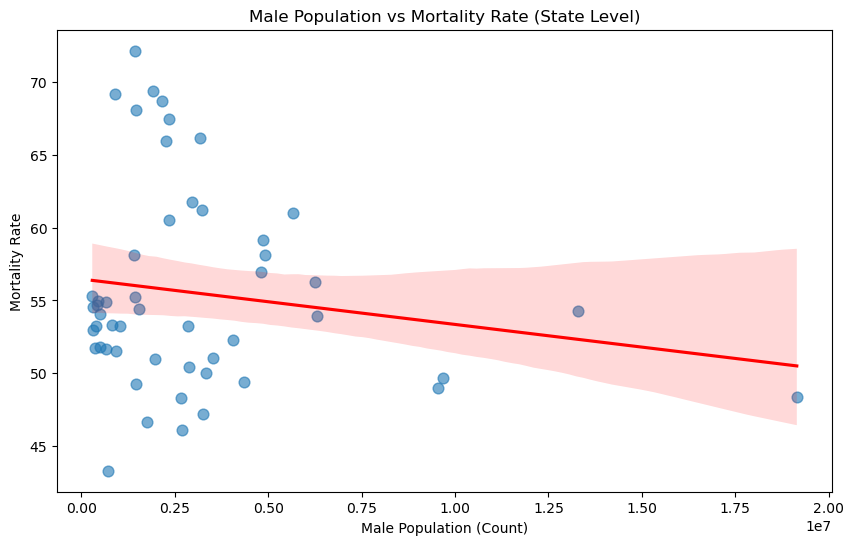

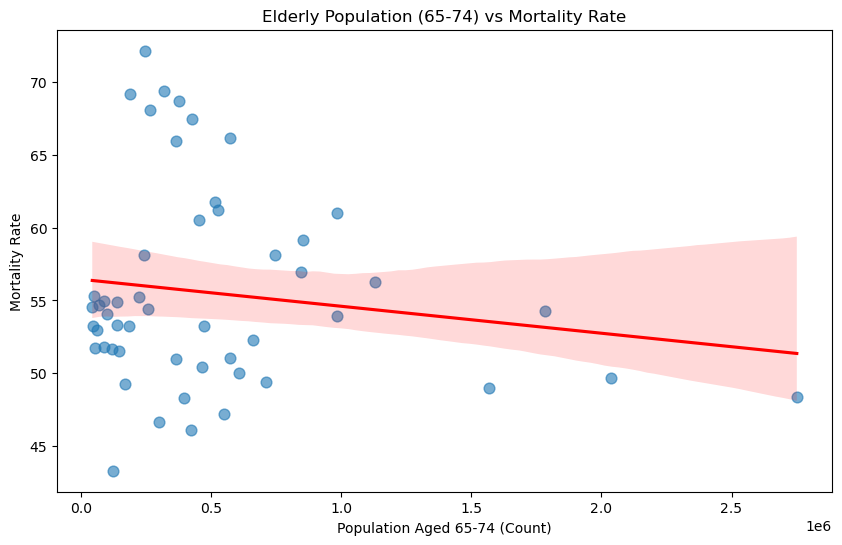

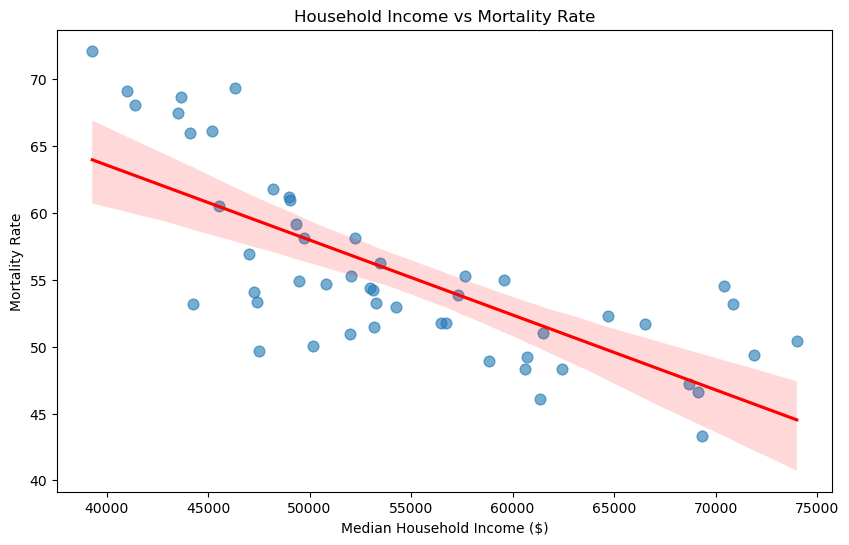

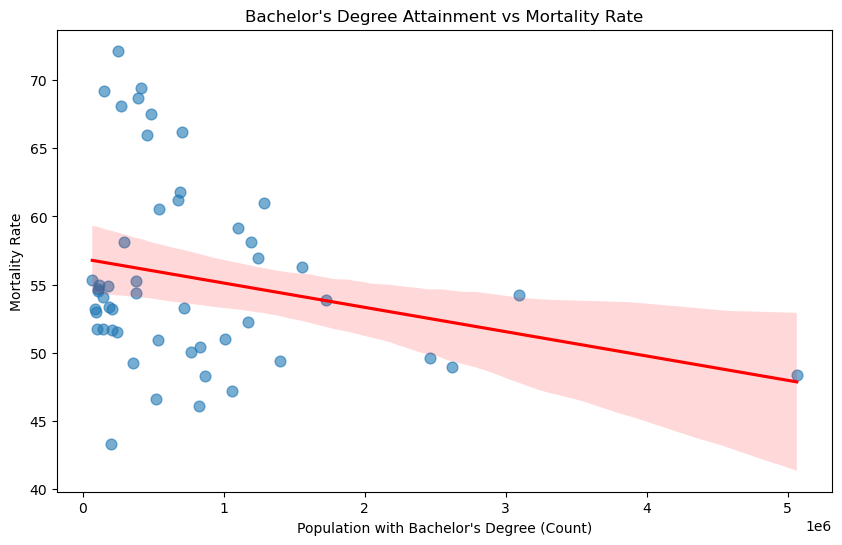

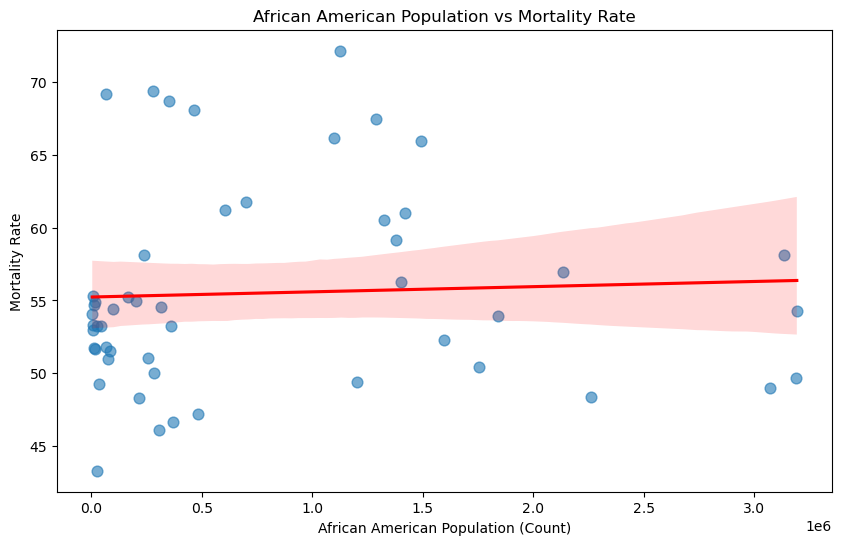

In [31]:
# Section 3O: Race Distribution by State
# get race proportions by state
race_state = merged_data.groupby('State').agg({
    'Race_White': 'mean',
    'Race_Black or African American': 'mean',
    'Race_Asian': 'mean',
    'Race_American Indian and Alaska Native': 'mean'
}).reset_index()

# select top 10 states by population
top_states = merged_data.groupby('State')['Age_25 to 34 years'].mean().nlargest(10).index
race_state_top = race_state[race_state['State'].isin(top_states)]

# melt for plotting
race_state_long = race_state_top.melt(
    id_vars='State',
    value_vars=[
        'Race_White',
        'Race_Black or African American',
        'Race_Asian',
        'Race_American Indian and Alaska Native'
    ],
    var_name='Race',
    value_name='Population'
)

# clean race names
race_state_long['Race'] = race_state_long['Race'].str.replace('Race_', '')

# plot race distribution by state
plt.figure(figsize=(12, 6))
sns.barplot(
    data=race_state_long,
    x='State',
    y='Population',
    hue='Race'
)
plt.title('Race Distribution by State')
plt.ylabel('Average Population')
plt.xlabel('State')
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# ml model Comparison (Improved)
plt.figure(figsize=(15, 5))

# MSE Plot
plt.subplot(1, 3, 1)
sns.barplot(x='Model', y='MSE', data=results_df, palette='coolwarm')
plt.title('Model Comparison: MSE')
plt.xticks(rotation=45)
plt.ylim(0, results_df['MSE'].max() * 1.1)

# RMSE Plot
plt.subplot(1, 3, 2)
sns.barplot(x='Model', y='RMSE', data=results_df, palette='coolwarm')
plt.title('Model Comparison: RMSE')
plt.xticks(rotation=45)
plt.ylim(0, results_df['RMSE'].max() * 1.1)

# R-squared Plot
plt.subplot(1, 3, 3)
sns.barplot(x='Model', y='R-squared', data=results_df, palette='coolwarm')
plt.title('Model Comparison: R-squared')
plt.xticks(rotation=45)
plt.ylim(0, 1)

plt.tight_layout()
plt.show()


# Figure 3: Gender vs Mortality
gender_vars = ['Gender_Male', 'Gender_Female', 'Age-adjusted Death Rate']
gender_data = merged_data.groupby('State')[gender_vars].mean().reset_index()

plt.figure(figsize=(10,6))
sns.regplot(
    x='Gender_Male',
    y='Age-adjusted Death Rate',
    data=gender_data,
    scatter_kws={'s': 60, 'alpha': 0.6},
    line_kws={'color': 'red'}
)
plt.title('Male Population vs Mortality Rate (State Level)')
plt.xlabel('Male Population (Count)')
plt.ylabel('Mortality Rate')
plt.show()

# Figure 4: Age vs Mortality
age_data = merged_data.groupby('State').agg({
    'Age_65 to 74 years': 'mean',
    'Age-adjusted Death Rate': 'mean'
}).reset_index()

plt.figure(figsize=(10,6))
sns.regplot(
    x='Age_65 to 74 years',
    y='Age-adjusted Death Rate',
    data=age_data,
    scatter_kws={'s': 60, 'alpha': 0.6},
    line_kws={'color': 'red'}
)
plt.title('Elderly Population (65-74) vs Mortality Rate')
plt.xlabel('Population Aged 65-74 (Count)')
plt.ylabel('Mortality Rate')
plt.show()


# Figure 5: Income vs Mortality
income_data = merged_data.groupby('State').agg({
    'Median_Household_Income': 'mean',
    'Age-adjusted Death Rate': 'mean'
}).reset_index()

plt.figure(figsize=(10,6))
sns.regplot(
    x='Median_Household_Income',
    y='Age-adjusted Death Rate',
    data=income_data,
    scatter_kws={'s': 60, 'alpha': 0.6},
    line_kws={'color': 'red'}
)
plt.title('Household Income vs Mortality Rate')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Mortality Rate')
plt.show()

# Figure 6: Education vs Mortality
edu_data = merged_data.groupby('State').agg({
    "Bachelor's degree": 'mean',
    'Age-adjusted Death Rate': 'mean'
}).reset_index()

plt.figure(figsize=(10,6))
sns.regplot(
    x="Bachelor's degree",
    y='Age-adjusted Death Rate',
    data=edu_data,
    scatter_kws={'s': 60, 'alpha': 0.6},
    line_kws={'color': 'red'}
)
plt.title("Bachelor's Degree Attainment vs Mortality Rate")
plt.xlabel("Population with Bachelor's Degree (Count)")
plt.ylabel('Mortality Rate')
plt.show()

# Figure 7: Race vs Mortality (Fixed)
race_data = merged_data.groupby('State').agg({
    'Race_Black or African American': 'mean',
    'Age-adjusted Death Rate': 'mean'
}).reset_index()

plt.figure(figsize=(10,6))
sns.regplot(
    x='Race_Black or African American',
    y='Age-adjusted Death Rate',
    data=race_data,
    scatter_kws={'s': 60, 'alpha': 0.6},
    line_kws={'color': 'red'}
)
plt.title('African American Population vs Mortality Rate')
plt.xlabel('African American Population (Count)')
plt.ylabel('Mortality Rate')
plt.show()


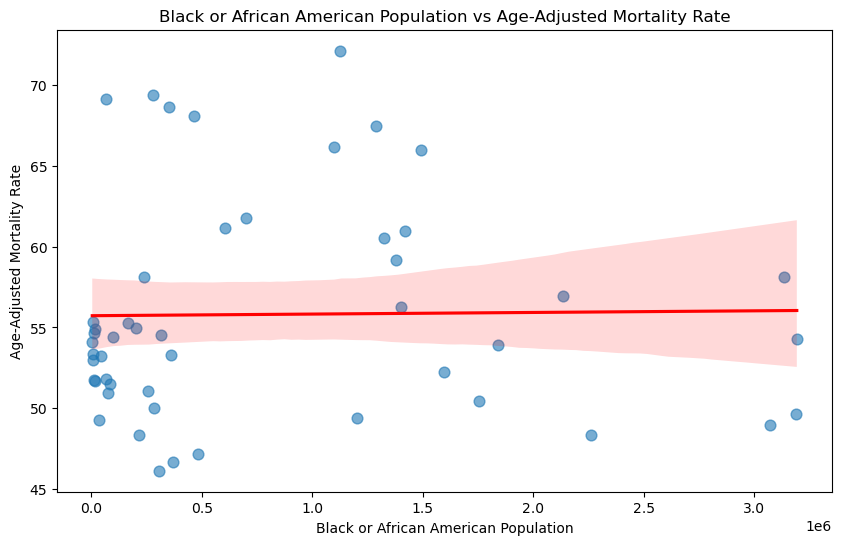

In [32]:
# Section 31: Geospatial Analysis Setup
from matplotlib.colors import LinearSegmentedColormap

# load the state shapefile
state_shp = gpd.read_file("tl_2024_us_state.shp")

# prepare mortality disparity metrics at state level
state_level = merged_data.groupby('State').agg({
    'Age-adjusted Death Rate': 'mean',
    'Gender_Female': 'mean',
    'Gender_Male': 'mean',
    'Race_White': 'mean',
    'Race_Black or African American': 'mean',
    'Race_American Indian and Alaska Native': 'mean',
    'Race_Asian': 'mean',
    'Race_Native Hawaiian and Other Pacific Islander': 'mean',
    'Race_Some other race': 'mean',
    'Race_Two or more races': 'mean',
    'Age_65 to 74 years': 'mean',
    "Bachelor's degree": 'mean',
    'Median_Household_Income': 'mean',
    '9th to 12th grade, no diploma': 'mean'
}).reset_index()

# merge with shapefile
state_geo = state_shp.merge(
    state_level,
    left_on='NAME',
    right_on='State',
    how='left'
)

# filter out non-contiguous states
contiguous = state_geo[~state_geo['STUSPS'].isin(['HI', 'AK', 'PR', 'AS', 'GU', 'VI', 'MP'])]

# create custom color maps
mortality_cmap = LinearSegmentedColormap.from_list('mortality', ['#ffffcc','#ffeda0','#fed976','#feb24c','#fd8d3c','#fc4e2a','#e31a1c','#bd0026','#800026'])
disparity_cmap = LinearSegmentedColormap.from_list('disparity', ['#2166ac','#4393c3','#92c5de','#d1e5f0','#f7f7f7','#fddbc7','#f4a582','#d6604d','#b2182b'])

# filter out non-contiguous states
contiguous = state_geo[~state_geo['STUSPS'].isin(['HI', 'AK', 'PR', 'AS', 'GU', 'VI', 'MP'])]

# prepare data for scatter plot
race_vs_mortality = contiguous[['Race_Black or African American', 'Age-adjusted Death Rate']].dropna()

# plotting the scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(
    x='Race_Black or African American',
    y='Age-adjusted Death Rate',
    data=race_vs_mortality,
    scatter_kws={'s': 60, 'alpha': 0.6},
    line_kws={'color': 'red'}
)
plt.title('Black or African American Population vs Age-Adjusted Mortality Rate')
plt.xlabel('Black or African American Population')
plt.ylabel('Age-Adjusted Mortality Rate')
plt.show()


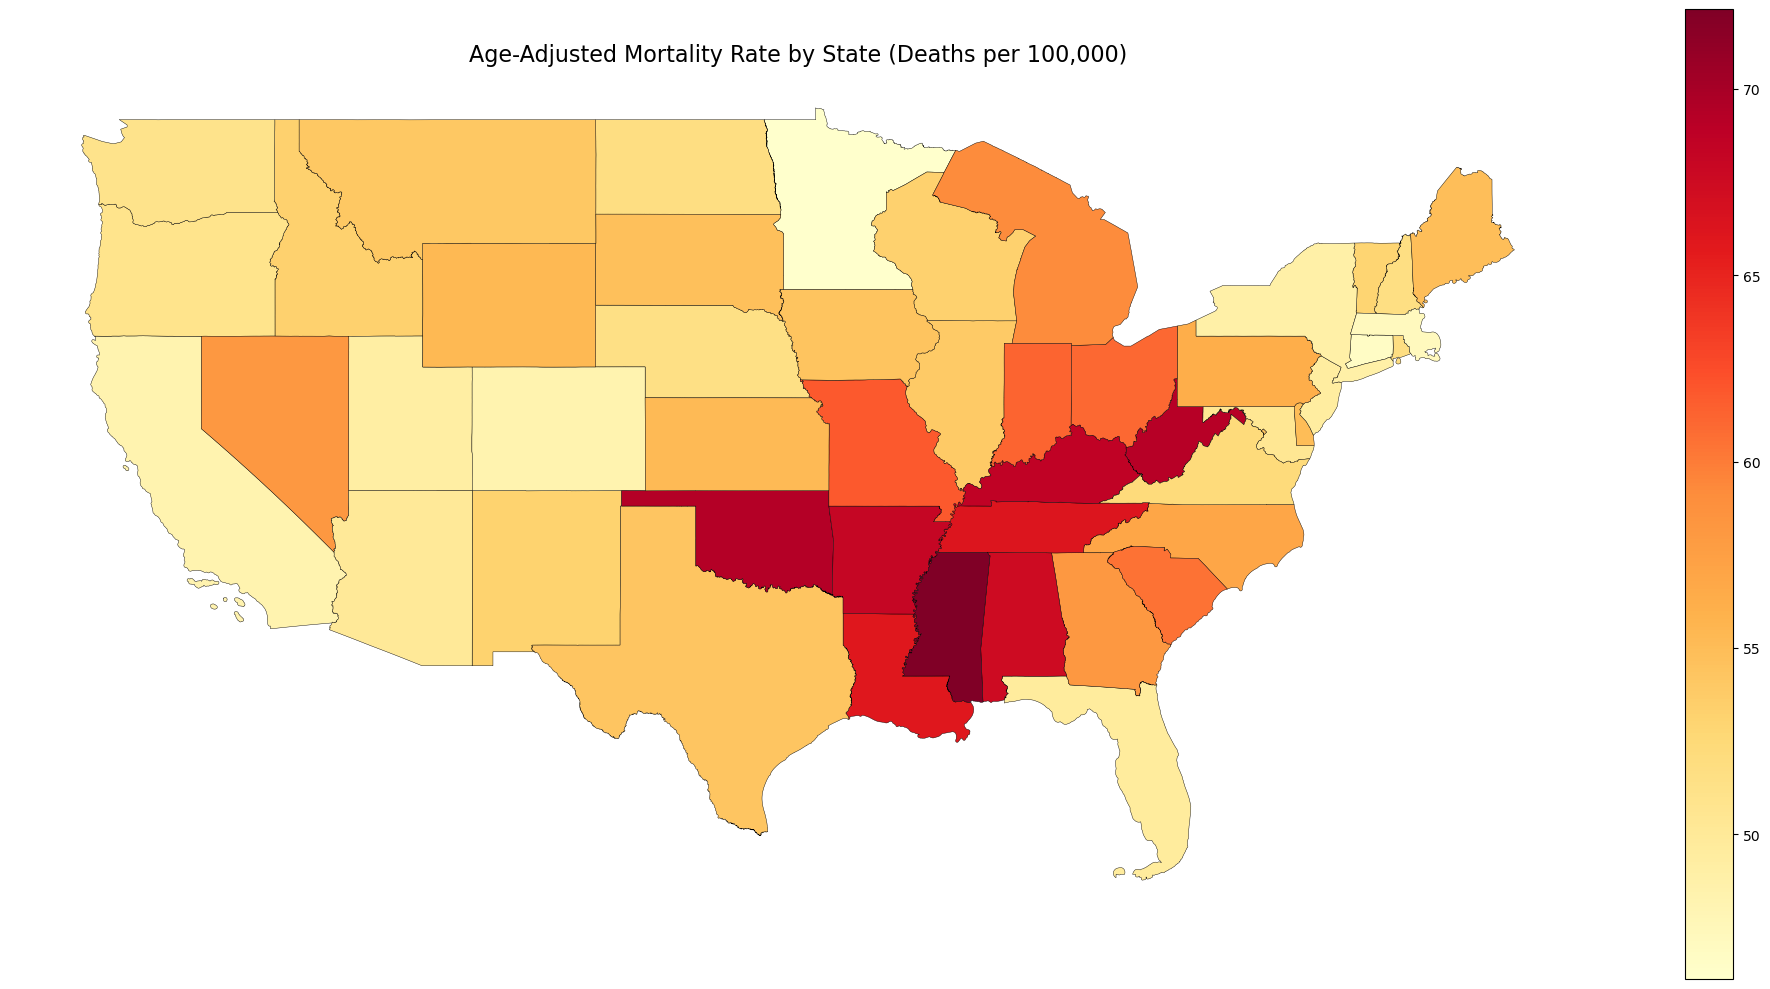

In [33]:
# Section 32: Base Mortality Rate Map
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
contiguous.plot(
    column='Age-adjusted Death Rate',
    cmap=mortality_cmap,
    legend=True,
    ax=ax,
    edgecolor='black',
    linewidth=0.3,
    missing_kwds={'color': 'lightgrey'}
)
plt.title('Age-Adjusted Mortality Rate by State (Deaths per 100,000)', fontsize=16)
ax.set_axis_off()
plt.tight_layout()
plt.show()

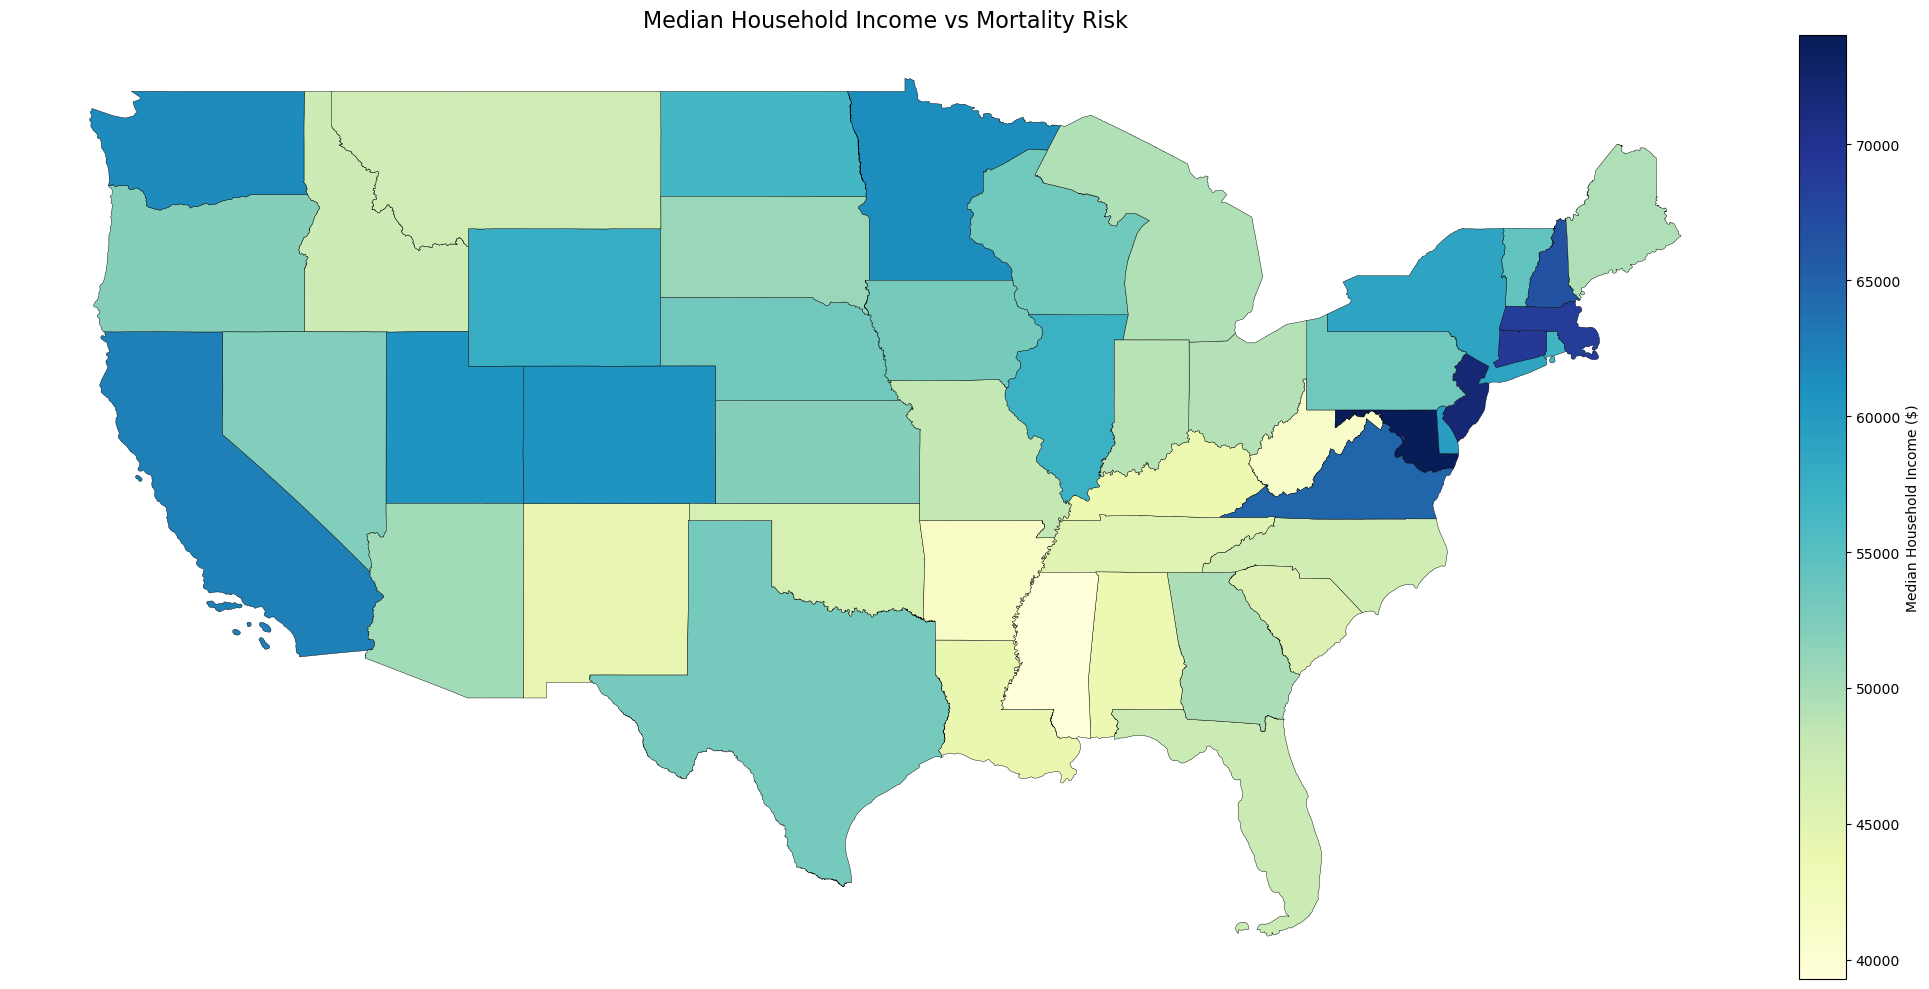

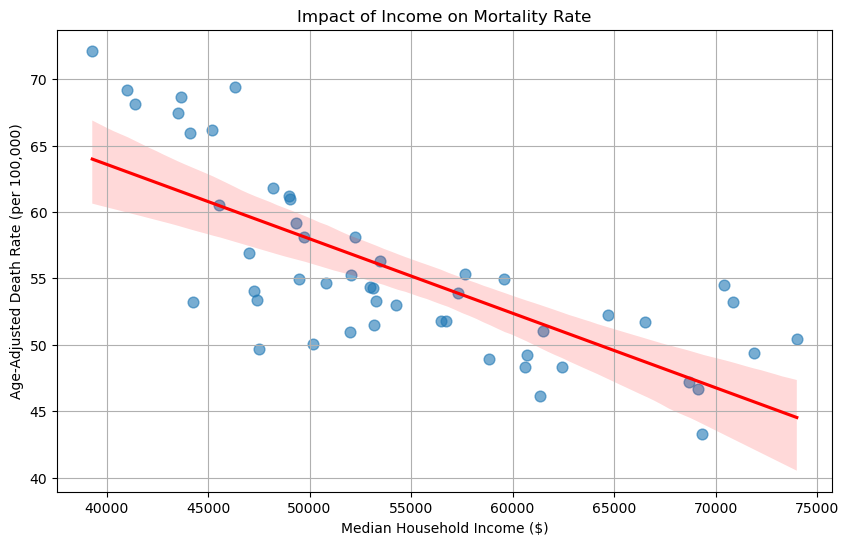

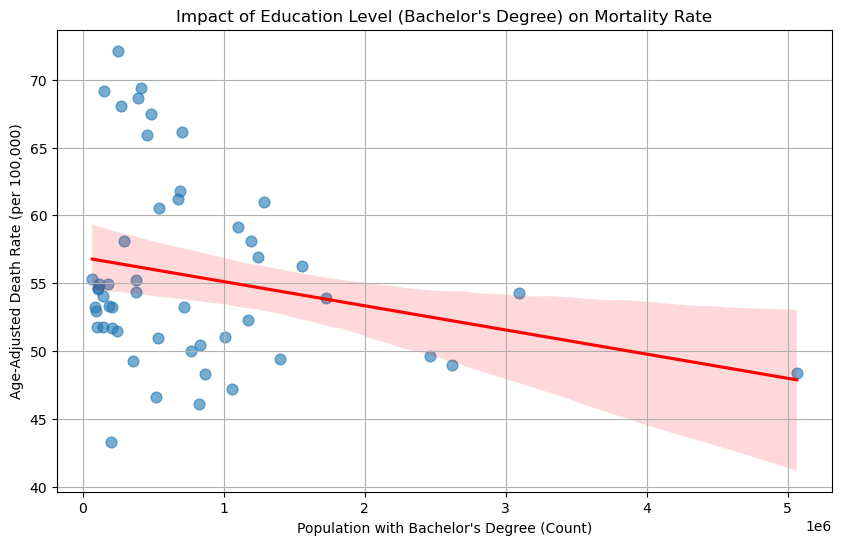

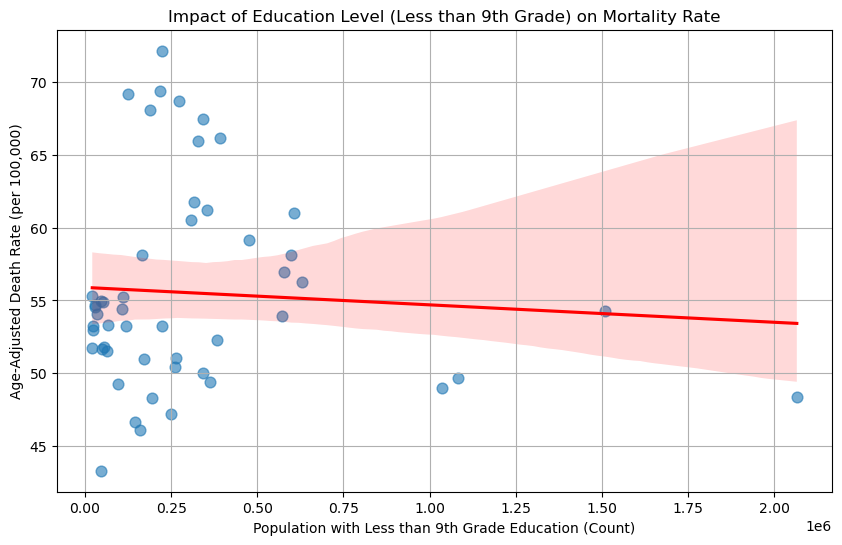

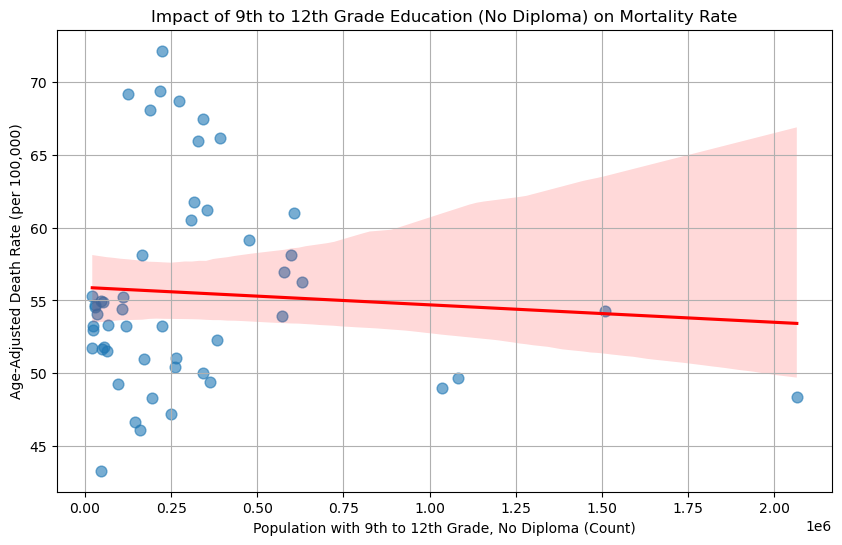

Index(['REGION', 'DIVISION', 'STATEFP', 'STATENS', 'GEOID', 'GEOIDFQ',
       'STUSPS', 'NAME', 'LSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'geometry', 'State', 'Age-adjusted Death Rate',
       'Gender_Female', 'Gender_Male', 'Race_White',
       'Race_Black or African American',
       'Race_American Indian and Alaska Native', 'Race_Asian',
       'Race_Native Hawaiian and Other Pacific Islander',
       'Race_Some other race', 'Race_Two or more races', 'Age_65 to 74 years',
       'Bachelor's degree', 'Median_Household_Income',
       '9th to 12th grade, no diploma'],
      dtype='object')


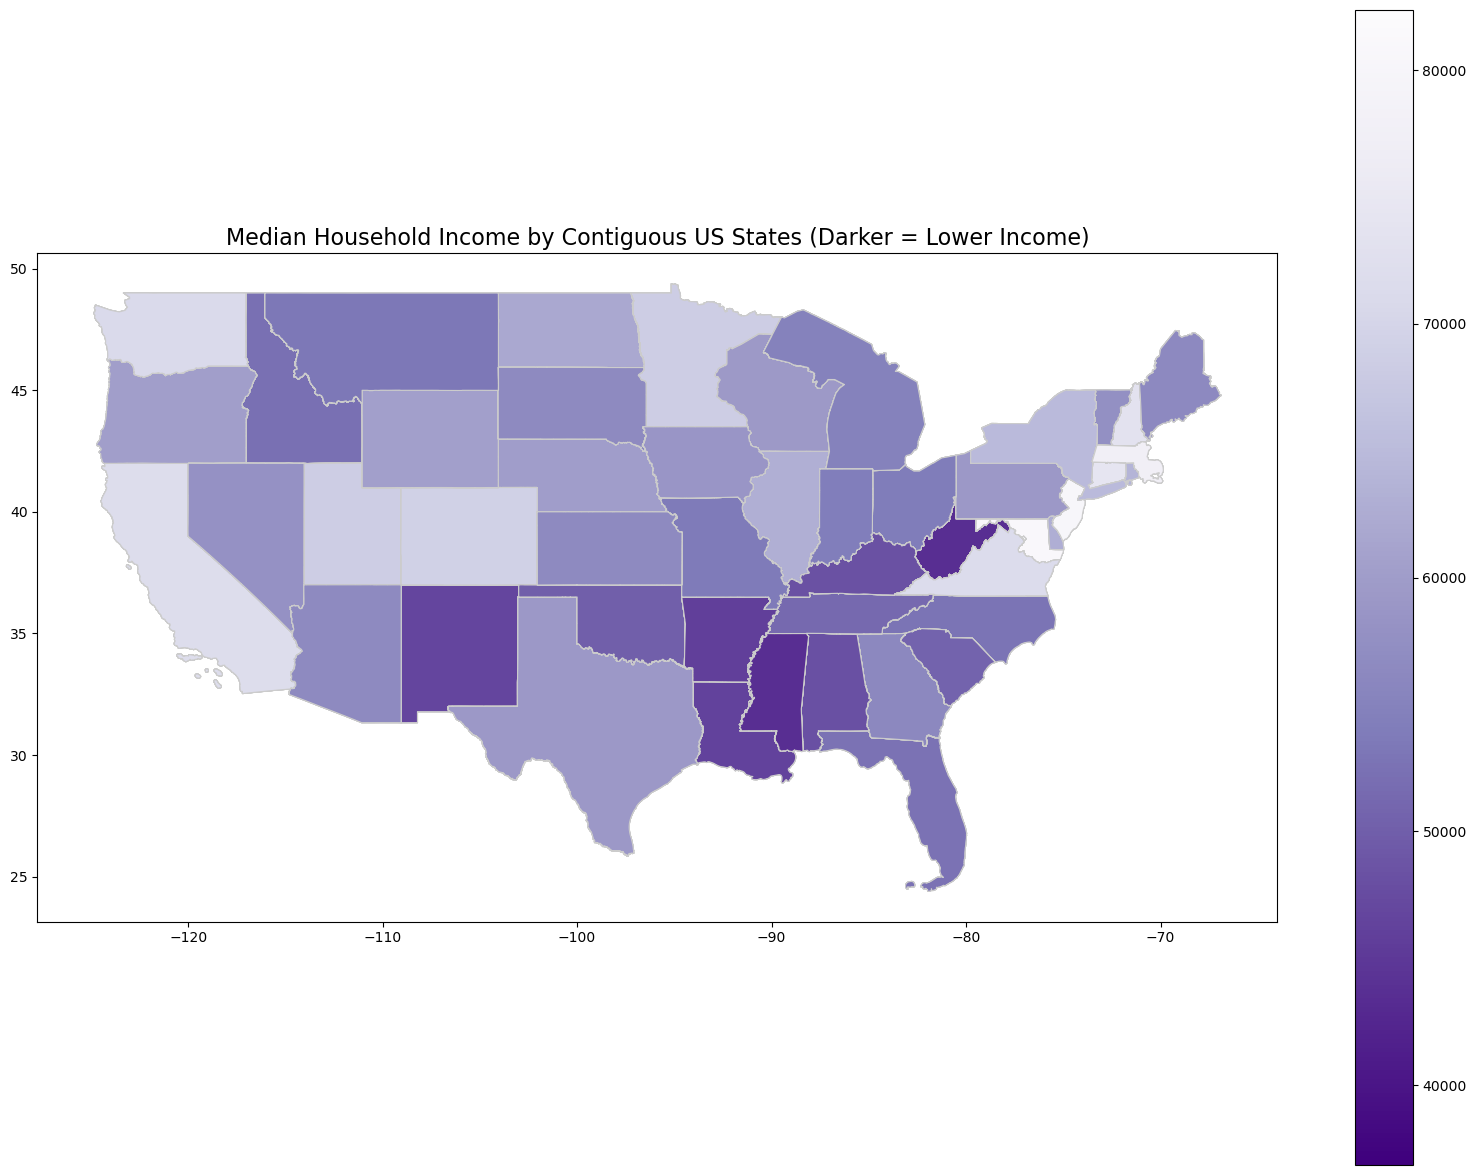

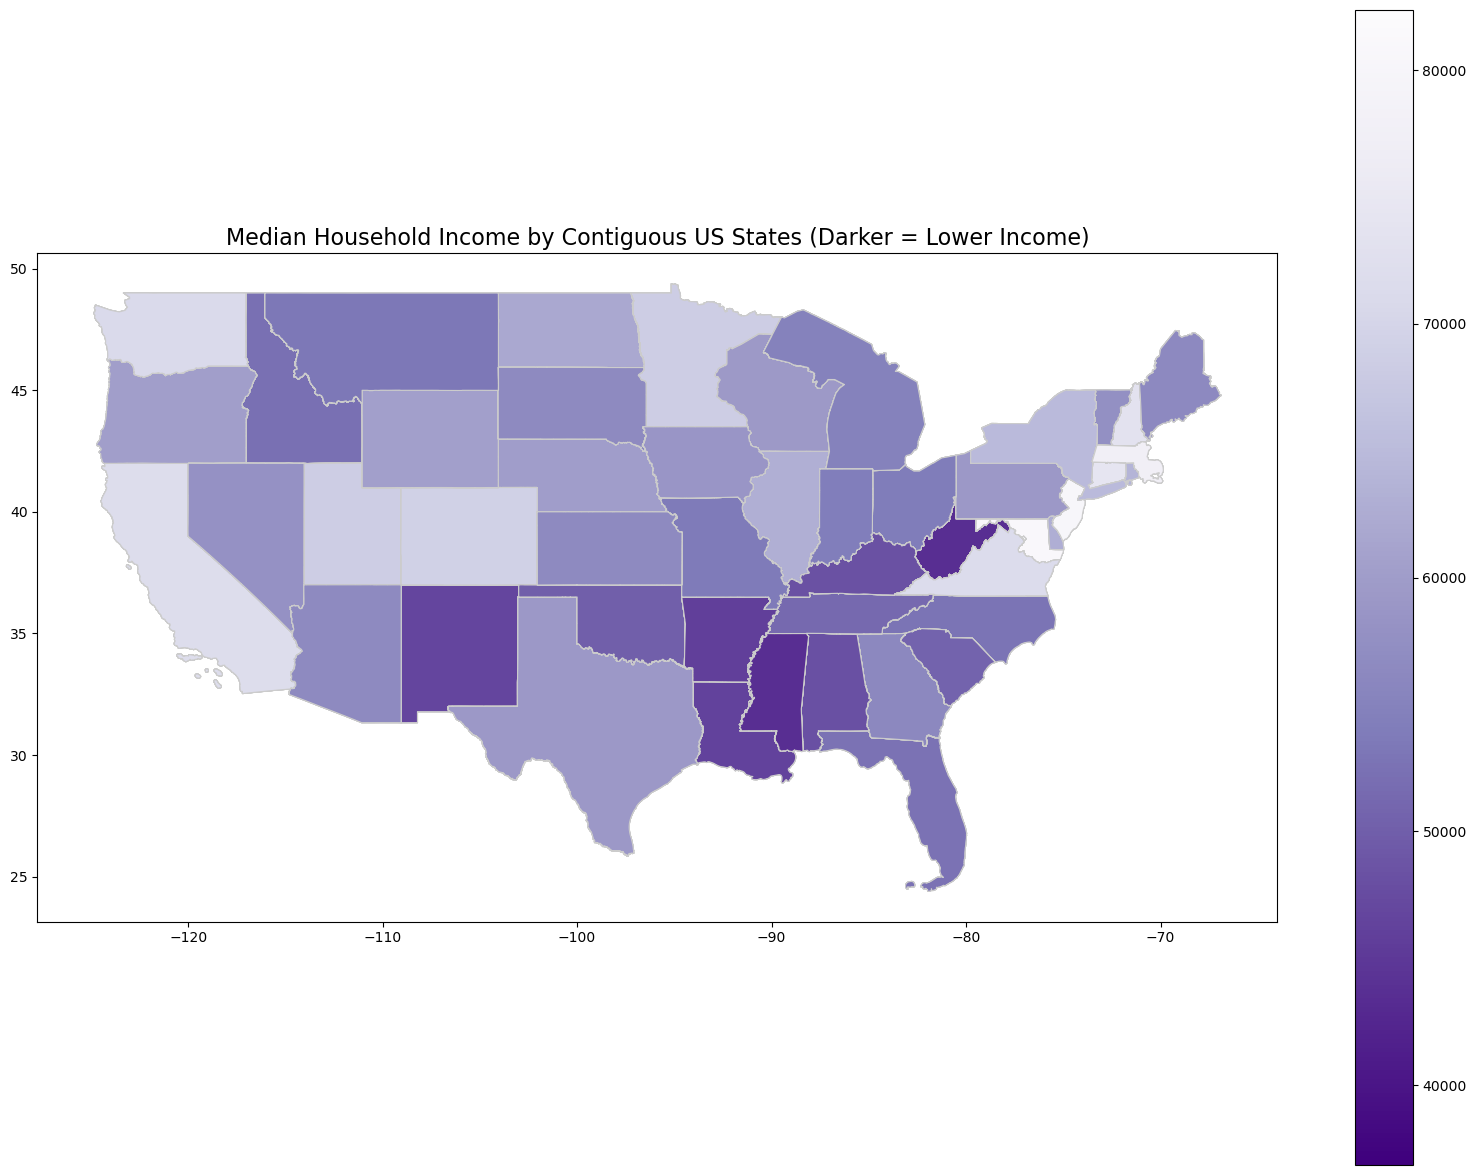

In [34]:
# Section 33: Income Disparity Map
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
plot = contiguous.plot(
    column='Median_Household_Income',
    cmap='YlGnBu',
    legend=False,  # Disable the built-in legend
    ax=ax,
    edgecolor='black',
    linewidth=0.3
)

plt.title('Median Household Income vs Mortality Risk', fontsize=16)
ax.set_axis_off()

# add a side color bar
sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=contiguous['Median_Household_Income'].min(), vmax=contiguous['Median_Household_Income'].max()))
sm._A = []  # This line allows us to plot the color bar
plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.02, label='Median Household Income ($)')

plt.tight_layout()
plt.show()

# prepare data for scatter plot
income_vs_mortality = state_geo[['Median_Household_Income', 'Age-adjusted Death Rate']].dropna()

# plotting the scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(
    x='Median_Household_Income',
    y='Age-adjusted Death Rate',
    data=income_vs_mortality,
    scatter_kws={'s': 60, 'alpha': 0.6},
    line_kws={'color': 'red'}
)

# adding titles and labels
plt.title('Impact of Income on Mortality Rate')
plt.xlabel('Median Household Income ($)')
plt.ylabel('Age-Adjusted Death Rate (per 100,000)')
plt.grid(True)
plt.show()


#bachelor\'s degre
education_vs_mortality = state_geo[['Bachelor\'s degree', 'Age-adjusted Death Rate']].dropna()

# plotting the scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(
    x='Bachelor\'s degree',
    y='Age-adjusted Death Rate',
    data=education_vs_mortality,
    scatter_kws={'s': 60, 'alpha': 0.6},
    line_kws={'color': 'red'}
)

# adding titles and labels
plt.title("Impact of Education Level (Bachelor's Degree) on Mortality Rate")
plt.xlabel("Population with Bachelor's Degree (Count)")
plt.ylabel('Age-Adjusted Death Rate (per 100,000)')
plt.grid(True)
plt.show()


# prepare data for scatter plot
education_vs_mortality = state_geo[['9th to 12th grade, no diploma', 'Age-adjusted Death Rate']].dropna()

# plotting the scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(
    x='9th to 12th grade, no diploma',
    y='Age-adjusted Death Rate',
    data=education_vs_mortality,
    scatter_kws={'s': 60, 'alpha': 0.6},
    line_kws={'color': 'red'}
)

# adding titles and labels
plt.title("Impact of Education Level (Less than 9th Grade) on Mortality Rate")
plt.xlabel("Population with Less than 9th Grade Education (Count)")
plt.ylabel('Age-Adjusted Death Rate (per 100,000)')
plt.grid(True)
plt.show()

# plotting the scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(
    x='9th to 12th grade, no diploma',
    y='Age-adjusted Death Rate',
    data=education_vs_mortality,
    scatter_kws={'s': 60, 'alpha': 0.6},
    line_kws={'color': 'red'}
)

# adding titles and labels
plt.title("Impact of 9th to 12th Grade Education (No Diploma) on Mortality Rate")
plt.xlabel("Population with 9th to 12th Grade, No Diploma (Count)")
plt.ylabel('Age-Adjusted Death Rate (per 100,000)')
plt.grid(True)
plt.show()


# check all column names in your state_geo dataframe
print(state_geo.columns)

if 'contiguous_states' not in locals():
    contiguous_states = states_geo[~states_geo['STUSPS'].isin(['HI', 'AK', 'PR', 'GU', 'VI', 'MP', 'AS'])]

# ploting income levels
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
contiguous_states.plot(
    column='Median_Household_Income',  
    cmap='Purples_r', 
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True
)

plt.title('Median Household Income by Contiguous US States (Darker = Lower Income)', fontsize=16)
plt.show()

# ploting income levels
fig, ax = plt.subplots(1, 1, figsize=(20, 15))
contiguous_states.plot(
    column='Median_Household_Income',  
    cmap='Purples_r', 
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True
)

plt.title('Median Household Income by Contiguous US States (Darker = Lower Income)', fontsize=16)
plt.show()

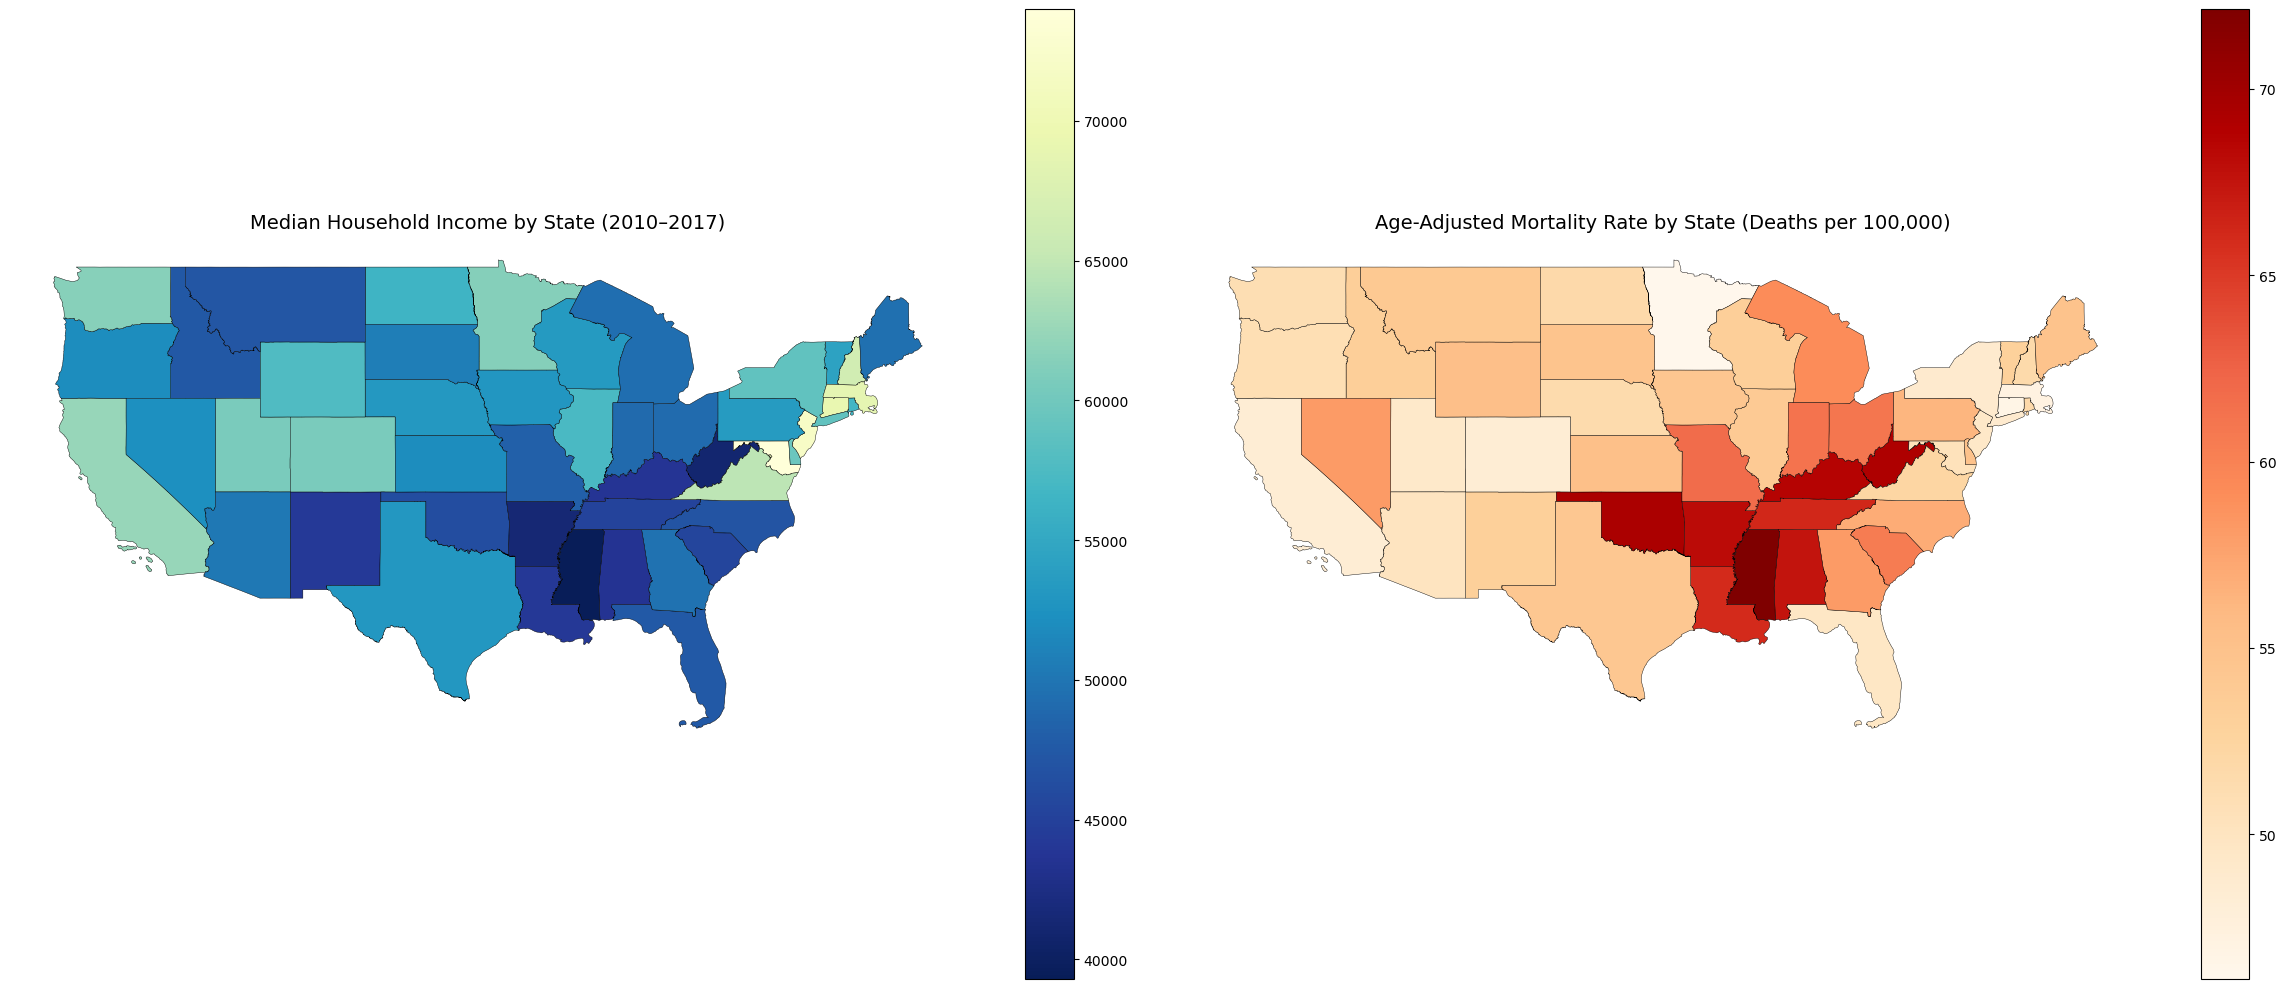

In [35]:
# Section 34: Side-by-Side Comparison of Income and Mortality Maps

fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# aap 1: median income
contiguous.plot(
    column='Median_Household_Income',
    cmap='YlGnBu_r',
    legend=True,
    ax=axes[0],
    edgecolor='black',
    linewidth=0.3,
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)
axes[0].set_title('Median Household Income by State (2010–2017)', fontsize=14)
axes[0].set_axis_off()

# map 2: age-adjusted death rate
contiguous.plot(
    column='Age-adjusted Death Rate',
    cmap='OrRd',
    legend=True,
    ax=axes[1],
    edgecolor='black',
    linewidth=0.3,
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)
axes[1].set_title('Age-Adjusted Mortality Rate by State (Deaths per 100,000)', fontsize=14)
axes[1].set_axis_off()

plt.tight_layout()
plt.show()


Average U.S. Population per Year by Race (2010–2017):
• White: 2,330,316,811
• Black or African American: 401,209,831


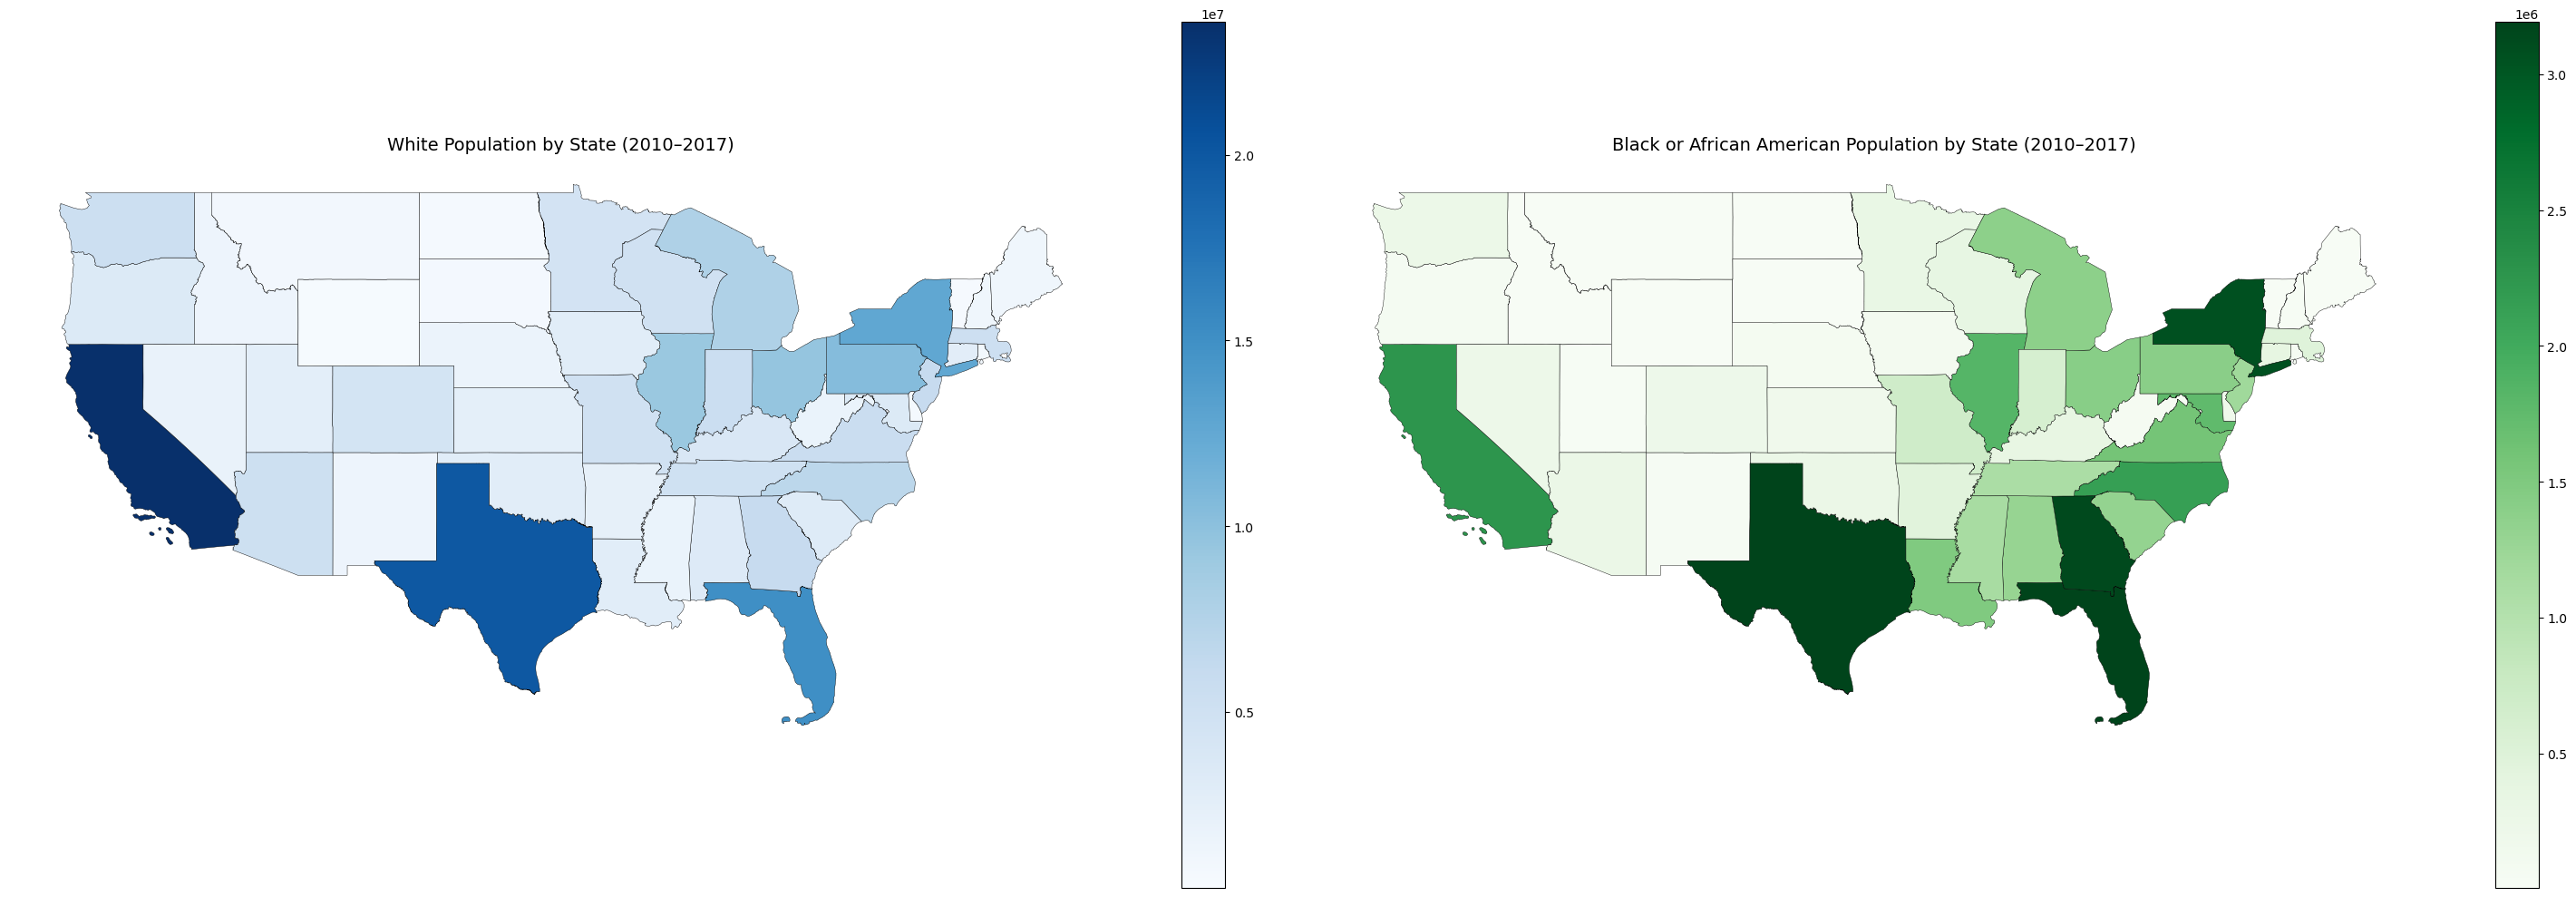

In [36]:
# Section 35: Racial Demographics Summary and Geographic Distribution (2010–2017)

# filter only the years 2010–2017 to be sure
filtered_years = merged_data[merged_data['Year'].between(2010, 2017)]

# total sum over all states and all years
total_white = filtered_years['Race_White'].sum()
total_black = filtered_years['Race_Black or African American'].sum()

# average by number of years (2010–2017 = 8 years)
years = filtered_years['Year'].nunique()

avg_white = total_white / years
avg_black = total_black / years

# print results
print("Average U.S. Population per Year by Race (2010–2017):")
print(f"• White: {avg_white:,.0f}")
print(f"• Black or African American: {avg_black:,.0f}")

# map plotting

fig, axes = plt.subplots(1, 2, figsize=(30, 10))

# map 1: white population
contiguous.plot(
    column='Race_White',
    cmap='Blues',
    legend=True,
    ax=axes[0],
    edgecolor='black',
    linewidth=0.3,
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)
axes[0].set_title('White Population by State (2010–2017)', fontsize=14)
axes[0].set_axis_off()

# map 2: black or african american population
contiguous.plot(
    column='Race_Black or African American',
    cmap='Greens',
    legend=True,
    ax=axes[1],
    edgecolor='black',
    linewidth=0.3,
    missing_kwds={'color': 'lightgrey', 'label': 'No data'}
)
axes[1].set_title('Black or African American Population by State (2010–2017)', fontsize=14)
axes[1].set_axis_off()

plt.tight_layout()
plt.show()
